Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading point cloud...
Original points: 124837
Point cloud bounds:
  X: -247.433 to 376.517
  Y: -563.497 to 178.098
  Z: 294.510 to 858.466

Point cloud centroid: [  13.01882882 -196.3002066   596.35084109]
Standard deviation: [169.1674088  146.4873525  107.47303719]
Points after outlier removal: 124241

Displaying original point cloud...
Displaying cleaned point cloud...

Point density analysis:
  Average nearest neighbor distance: 13.866973
  Std dev of distances: 3.837373
  Min distance: 5.426145
  Max distance: 40.689770

Suggested clustering parameters:
  eps: 15.949151
  min_samples: 124

Point density analysis:
  Average nearest neighbor distance: 13.994347
  Std dev of distances: 4.091634
  Min distance: 6.260109
  Max distance: 64.991336

Suggested clustering parameters:
  eps: 16.125025
  min_samples: 124

Te

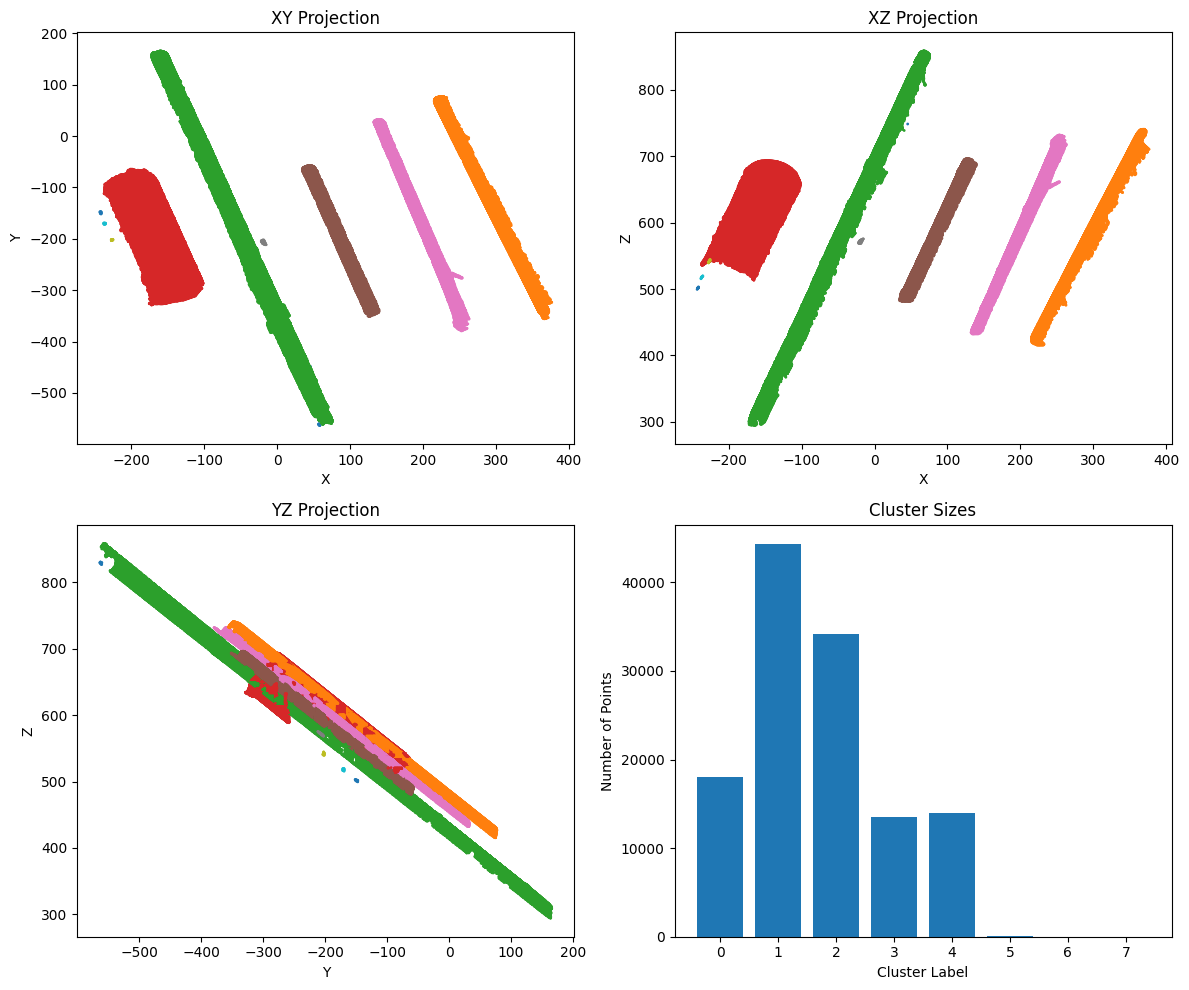


Recommended parameters for cylinder fitting:
  eps = 8.062513
  min_samples = 20


In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

def visualize_pointcloud(file_path):
    """Load and visualize point cloud with basic analysis"""
    
    # Load point cloud
    print("Loading point cloud...")
    pcd = o3d.io.read_point_cloud(file_path)
    points = np.asarray(pcd.points)
    
    print(f"Original points: {len(points)}")
    print(f"Point cloud bounds:")
    print(f"  X: {np.min(points[:, 0]):.3f} to {np.max(points[:, 0]):.3f}")
    print(f"  Y: {np.min(points[:, 1]):.3f} to {np.max(points[:, 1]):.3f}")
    print(f"  Z: {np.min(points[:, 2]):.3f} to {np.max(points[:, 2]):.3f}")
    
    # Calculate point cloud statistics
    centroid = np.mean(points, axis=0)
    std_dev = np.std(points, axis=0)
    print(f"\nPoint cloud centroid: {centroid}")
    print(f"Standard deviation: {std_dev}")
    
    # Remove outliers
    pcd_clean, outlier_indices = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    points_clean = np.asarray(pcd_clean.points)
    print(f"Points after outlier removal: {len(points_clean)}")
    
    # Visualize original point cloud
    print("\nDisplaying original point cloud...")
    pcd.paint_uniform_color([0.5, 0.5, 0.5])  # Gray color
    o3d.visualization.draw_geometries([pcd], 
                                    window_name="Original Point Cloud",
                                    width=1024, height=768)
    
    # Visualize cleaned point cloud
    print("Displaying cleaned point cloud...")
    pcd_clean.paint_uniform_color([0.2, 0.6, 0.8])  # Blue color
    o3d.visualization.draw_geometries([pcd_clean], 
                                    window_name="Cleaned Point Cloud",
                                    width=1024, height=768)
    
    return pcd_clean, points_clean

def analyze_point_density(points, sample_size=1000):
    """Analyze point density to suggest clustering parameters"""
    
    # Sample points for density analysis
    if len(points) > sample_size:
        indices = np.random.choice(len(points), sample_size, replace=False)
        sample_points = points[indices]
    else:
        sample_points = points
    
    # Calculate nearest neighbor distances
    from sklearn.neighbors import NearestNeighbors
    
    nbrs = NearestNeighbors(n_neighbors=10).fit(sample_points)
    distances, indices = nbrs.kneighbors(sample_points)
    
    # Average distance to nearest neighbors (excluding self)
    avg_distances = np.mean(distances[:, 1:], axis=1)
    
    print(f"\nPoint density analysis:")
    print(f"  Average nearest neighbor distance: {np.mean(avg_distances):.6f}")
    print(f"  Std dev of distances: {np.std(avg_distances):.6f}")
    print(f"  Min distance: {np.min(avg_distances):.6f}")
    print(f"  Max distance: {np.max(avg_distances):.6f}")
    
    # Suggest clustering parameters
    suggested_eps = np.percentile(avg_distances, 75)  # 75th percentile
    print(f"\nSuggested clustering parameters:")
    print(f"  eps: {suggested_eps:.6f}")
    print(f"  min_samples: {max(10, len(points) // 1000)}")
    
    return suggested_eps, max(10, len(points) // 1000)

def test_clustering_parameters(points, eps_values=None, min_samples_values=None):
    """Test different clustering parameters"""
    
    if eps_values is None:
        # Suggest range based on point density
        suggested_eps, _ = analyze_point_density(points)
        eps_values = [suggested_eps * 0.5, suggested_eps, suggested_eps * 2, suggested_eps * 5]
    
    if min_samples_values is None:
        min_samples_values = [10, 20, 50, 100]
    
    print(f"\nTesting clustering parameters...")
    best_params = None
    best_clusters = 0
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
            labels = clustering.labels_
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            print(f"  eps={eps:.6f}, min_samples={min_samples}: "
                  f"{n_clusters} clusters, {n_noise} noise points")
            
            # Prefer configurations with 3-8 clusters (typical for rebar arrangements)
            if 3 <= n_clusters <= 8 and n_clusters > best_clusters:
                best_clusters = n_clusters
                best_params = (eps, min_samples)
    
    if best_params:
        print(f"\nBest parameters found: eps={best_params[0]:.6f}, min_samples={best_params[1]}")
        return best_params
    else:
        print(f"\nNo optimal parameters found. Using suggested values.")
        suggested_eps, suggested_min_samples = analyze_point_density(points)
        return suggested_eps, suggested_min_samples

def visualize_clustering(points, eps, min_samples):
    """Visualize clustering results"""
    
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    
    # Create point cloud for visualization
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Color points by cluster
    colors = plt.cm.tab10(labels / max(labels.max(), 1))[:, :3]
    colors[labels == -1] = [0, 0, 0]  # Black for noise
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    print(f"\nClustering results:")
    print(f"  Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
    print(f"  Noise points: {list(labels).count(-1)}")
    
    # Show clustered point cloud
    o3d.visualization.draw_geometries([pcd], 
                                    window_name="Clustered Point Cloud",
                                    width=1024, height=768)
    
    return labels

def main():
    file_path = r"C:\open3d-env\rebar\pcd20250808\0807_15.ply"
    
    # Step 1: Load and visualize
    pcd_clean, points_clean = visualize_pointcloud(file_path)
    
    # Step 2: Analyze point density
    suggested_eps, suggested_min_samples = analyze_point_density(points_clean)
    
    # Step 3: Test clustering parameters
    best_eps, best_min_samples = test_clustering_parameters(points_clean)
    
    # Step 4: Visualize clustering with best parameters
    labels = visualize_clustering(points_clean, best_eps, best_min_samples)
    
    # Step 5: Show 2D projections for better understanding
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # XY projection
    axes[0,0].scatter(points_clean[:, 0], points_clean[:, 1], c=labels, s=1, cmap='tab10')
    axes[0,0].set_title('XY Projection')
    axes[0,0].set_xlabel('X')
    axes[0,0].set_ylabel('Y')
    
    # XZ projection
    axes[0,1].scatter(points_clean[:, 0], points_clean[:, 2], c=labels, s=1, cmap='tab10')
    axes[0,1].set_title('XZ Projection')
    axes[0,1].set_xlabel('X')
    axes[0,1].set_ylabel('Z')
    
    # YZ projection
    axes[1,0].scatter(points_clean[:, 1], points_clean[:, 2], c=labels, s=1, cmap='tab10')
    axes[1,0].set_title('YZ Projection')
    axes[1,0].set_xlabel('Y')
    axes[1,0].set_ylabel('Z')
    
    # Histogram of cluster sizes
    unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
    axes[1,1].bar(unique_labels, counts)
    axes[1,1].set_title('Cluster Sizes')
    axes[1,1].set_xlabel('Cluster Label')
    axes[1,1].set_ylabel('Number of Points')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nRecommended parameters for cylinder fitting:")
    print(f"  eps = {best_eps:.6f}")
    print(f"  min_samples = {best_min_samples}")

if __name__ == "__main__":
    main()

Starting analysis on 124241 points...
Clustering completed in 3.112s - Found 6 clusters

Processing Cylinder 1/6 (18077 points)...
  Diameter: 17.80 mm (±0.70)
  Length: 552.90 mm
  RMSE: 0.9683
  Processing time: 0.319s

Processing Cylinder 2/6 (44248 points)...
  Diameter: 24.50 mm (±0.89)
  Length: 944.80 mm
  RMSE: 1.5695
  Processing time: 0.499s

Processing Cylinder 3/6 (34202 points)...
  Diameter: 75.90 mm (±0.37)
  Length: 272.69 mm
  RMSE: 1.3703
  Processing time: 0.418s

Processing Cylinder 4/6 (13564 points)...
  Diameter: 16.64 mm (±0.64)
  Length: 369.05 mm
  RMSE: 1.0319
  Processing time: 0.191s

Processing Cylinder 5/6 (13994 points)...
  Diameter: 14.32 mm (±0.48)
  Length: 520.78 mm
  RMSE: 1.1784
  Processing time: 0.187s

Processing Cylinder 6/6 (54 points)...
  Diameter: 80.12 mm (±0.01)
  Length: 7.64 mm
  RMSE: 0.0232
  Processing time: 0.016s

CYLINDER FITTING & SECTIONAL ANALYSIS RESULTS

DIMENSIONAL SUMMARY:
  Rebars detected: 6
  Average diameter: 38.21 ± 2

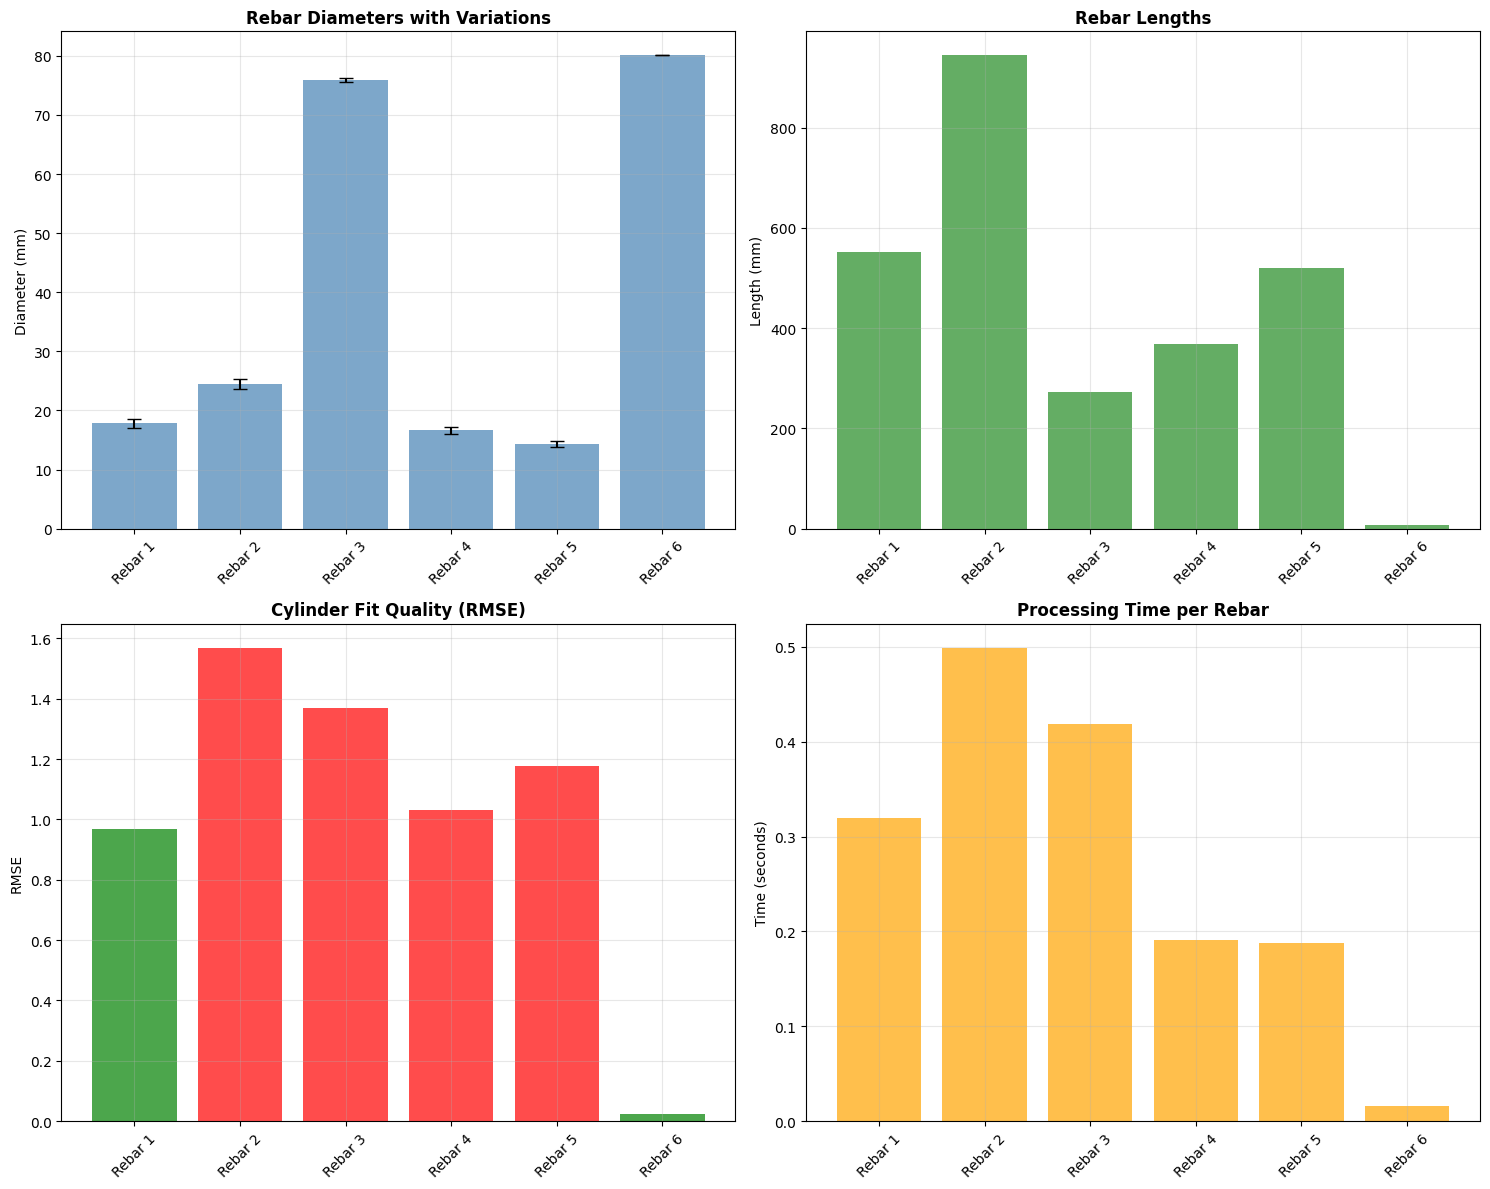

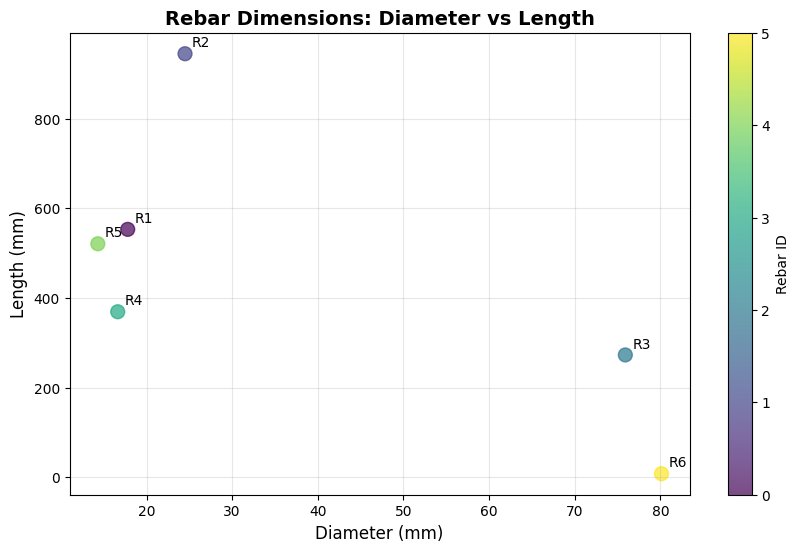

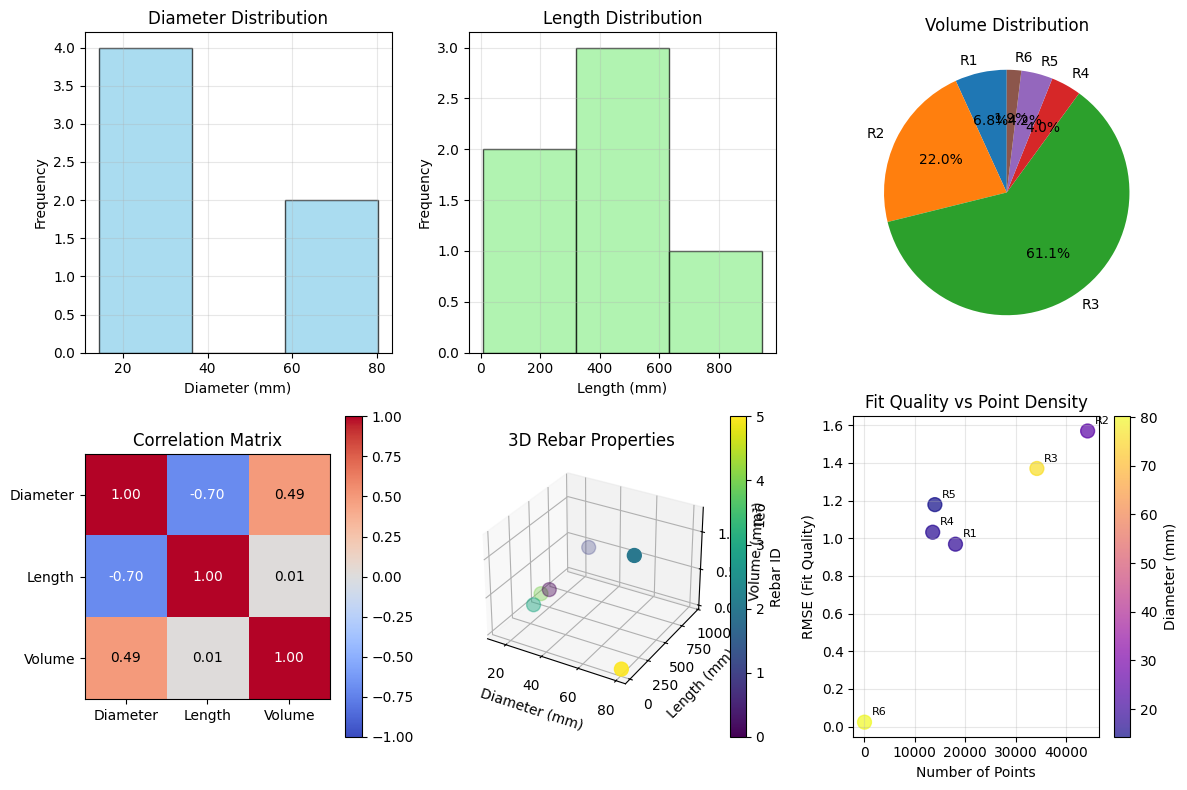

All visualizations completed!


In [5]:
import open3d as o3d
import numpy as np
from scipy.optimize import least_squares
import time
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_cylinder_mesh(center, axis, radius, length, resolution=20):
    """Create a cylinder mesh for visualization"""
    # Create cylinder geometry
    cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=radius, height=length, resolution=resolution)
    
    # Rotate cylinder to align with axis
    # Default cylinder is along Z-axis, we need to rotate to our axis
    z_axis = np.array([0, 0, 1])
    rotation_axis = np.cross(z_axis, axis)
    rotation_angle = np.arccos(np.clip(np.dot(z_axis, axis), -1.0, 1.0))
    
    if np.linalg.norm(rotation_axis) > 1e-6:
        rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
        rotation_matrix = cylinder.get_rotation_matrix_from_axis_angle(rotation_axis * rotation_angle)
        cylinder.rotate(rotation_matrix, center=[0, 0, 0])
    
    # Translate to center position
    cylinder.translate(center)
    
    return cylinder

def create_cylinder_wireframe(center, axis, radius, length, num_circles=10, points_per_circle=20):
    """Create wireframe representation of cylinder"""
    lines = []
    points = []
    
    # Create circles along the cylinder axis
    for i in range(num_circles):
        t = (i / (num_circles - 1) - 0.5) * length
        circle_center = center + t * axis
        
        # Create a circle perpendicular to axis
        # Find two perpendicular vectors to axis
        if abs(axis[0]) < 0.9:
            v1 = np.cross(axis, [1, 0, 0])
        else:
            v1 = np.cross(axis, [0, 1, 0])
        v1 = v1 / np.linalg.norm(v1)
        v2 = np.cross(axis, v1)
        v2 = v2 / np.linalg.norm(v2)
        
        circle_points = []
        for j in range(points_per_circle):
            angle = 2 * np.pi * j / points_per_circle
            point = circle_center + radius * (np.cos(angle) * v1 + np.sin(angle) * v2)
            points.append(point)
            circle_points.append(len(points) - 1)
        
        # Connect circle points
        for j in range(points_per_circle):
            lines.append([circle_points[j], circle_points[(j + 1) % points_per_circle]])
    
    # Connect corresponding points between circles
    if num_circles > 1:
        for j in range(points_per_circle):
            for i in range(num_circles - 1):
                p1_idx = i * points_per_circle + j
                p2_idx = (i + 1) * points_per_circle + j
                lines.append([p1_idx, p2_idx])
    
    # Create line set
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(points)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    
    return line_set

def visualize_sectional_analysis(cylinder_results):
    """Create plots for sectional analysis"""
    n_cylinders = len(cylinder_results)
    if n_cylinders == 0:
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Diameter comparison
    cylinder_ids = [f"Rebar {c['id']}" for c in cylinder_results]
    diameters = [c['diameter'] for c in cylinder_results]
    diameter_stds = [c['diameter_std'] for c in cylinder_results]
    
    axes[0,0].bar(cylinder_ids, diameters, yerr=diameter_stds, capsize=5, alpha=0.7, color='steelblue')
    axes[0,0].set_title('Rebar Diameters with Variations', fontsize=12, fontweight='bold')
    axes[0,0].set_ylabel('Diameter (mm)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Length comparison
    lengths = [c['length'] for c in cylinder_results]
    axes[0,1].bar(cylinder_ids, lengths, alpha=0.7, color='forestgreen')
    axes[0,1].set_title('Rebar Lengths', fontsize=12, fontweight='bold')
    axes[0,1].set_ylabel('Length (mm)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: RMSE (fit quality)
    rmse_values = [c['rmse'] for c in cylinder_results]
    colors = ['red' if rmse > np.mean(rmse_values) else 'green' for rmse in rmse_values]
    axes[1,0].bar(cylinder_ids, rmse_values, alpha=0.7, color=colors)
    axes[1,0].set_title('Cylinder Fit Quality (RMSE)', fontsize=12, fontweight='bold')
    axes[1,0].set_ylabel('RMSE')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Processing time
    processing_times = [c['fitting_time'] + c['analysis_time'] for c in cylinder_results]
    axes[1,1].bar(cylinder_ids, processing_times, alpha=0.7, color='orange')
    axes[1,1].set_title('Processing Time per Rebar', fontsize=12, fontweight='bold')
    axes[1,1].set_ylabel('Time (seconds)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Diameter vs Length scatter
    plt.figure(figsize=(10, 6))
    plt.scatter(diameters, lengths, s=100, alpha=0.7, c=range(len(diameters)), cmap='viridis')
    plt.xlabel('Diameter (mm)', fontsize=12)
    plt.ylabel('Length (mm)', fontsize=12)
    plt.title('Rebar Dimensions: Diameter vs Length', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add labels for each point
    for i, (d, l) in enumerate(zip(diameters, lengths)):
        plt.annotate(f'R{i+1}', (d, l), xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.colorbar(label='Rebar ID')
    plt.show()

def basic_cylinder_fitting_analysis():
    """Perform cylinder fitting and sectional analysis on clustered rebars"""
    
    # Load point cloud
    file_path = r"C:\open3d-env\rebar\pcd20250808\0807_15.ply"
    pcd = o3d.io.read_point_cloud(file_path)
    pcd_clean, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    points = np.asarray(pcd_clean.points)
    
    print(f"Starting analysis on {len(points)} points...")
    
    # Use optimal clustering parameters found
    eps = 8.326386
    min_samples = 50
    
    total_start_time = time.time()
    
    # Clustering
    cluster_start = time.time()
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    cluster_time = time.time() - cluster_start
    
    # Get clusters
    clusters = []
    for label in set(labels):
        if label != -1:  # Ignore noise
            cluster_points = points[labels == label]
            clusters.append(cluster_points)
    
    print(f"Clustering completed in {cluster_time:.3f}s - Found {len(clusters)} clusters")
    
    # Initialize results storage
    cylinder_results = []
    total_fitting_time = 0
    total_analysis_time = 0
    
    # Process each cluster
    for i, cluster_points in enumerate(clusters):
        print(f"\nProcessing Cylinder {i+1}/{len(clusters)} ({len(cluster_points)} points)...")
        
        # CYLINDER FITTING
        fitting_start = time.time()
        
        # Initial cylinder estimation using PCA
        pca = PCA(n_components=3)
        pca.fit(cluster_points)
        
        # Cylinder axis is the first principal component (longest dimension)
        axis = pca.components_[0]
        center = np.mean(cluster_points, axis=0)
        
        # Calculate radius by projecting points to plane perpendicular to axis
        relative_points = cluster_points - center
        projections_along_axis = np.dot(relative_points, axis)
        projected_on_axis = np.outer(projections_along_axis, axis)
        perpendicular_distances = relative_points - projected_on_axis
        distances_to_axis = np.linalg.norm(perpendicular_distances, axis=1)
        radius = np.mean(distances_to_axis)
        
        # Least squares refinement
        def cylinder_residuals(params, points):
            cx, cy, cz, ax, ay, az, r = params
            center_pt = np.array([cx, cy, cz])
            axis_vec = np.array([ax, ay, az])
            axis_vec = axis_vec / np.linalg.norm(axis_vec)
            
            # Distance from points to cylinder axis
            to_center = points - center_pt
            proj_lengths = np.dot(to_center, axis_vec)
            projections = np.outer(proj_lengths, axis_vec)
            perpendicular = to_center - projections
            distances = np.linalg.norm(perpendicular, axis=1)
            
            return distances - r
        
        initial_params = [center[0], center[1], center[2], axis[0], axis[1], axis[2], radius]
        result = least_squares(cylinder_residuals, initial_params, args=(cluster_points,))
        
        # Extract refined parameters
        refined_center = result.x[:3]
        refined_axis = result.x[3:6] / np.linalg.norm(result.x[3:6])
        refined_radius = result.x[6]
        rmse = np.sqrt(np.mean(result.fun**2))
        
        fitting_time = time.time() - fitting_start
        total_fitting_time += fitting_time
        
        # SECTIONAL ANALYSIS
        analysis_start = time.time()
        
        # Calculate cylinder length
        projections = np.dot(cluster_points - refined_center, refined_axis)
        length = np.max(projections) - np.min(projections)
        
        # Sectional diameter analysis (10 sections)
        num_sections = 10
        section_boundaries = np.linspace(np.min(projections), np.max(projections), num_sections + 1)
        section_diameters = []
        
        for j in range(num_sections):
            mask = (projections >= section_boundaries[j]) & (projections < section_boundaries[j+1])
            if np.sum(mask) < 5:  # Skip if too few points
                continue
                
            section_points = cluster_points[mask]
            section_center = refined_center + refined_axis * ((section_boundaries[j] + section_boundaries[j+1]) / 2)
            
            # Calculate diameter in this section
            relative = section_points - section_center
            perpendicular = relative - np.outer(np.dot(relative, refined_axis), refined_axis)
            section_distances = np.linalg.norm(perpendicular, axis=1)
            section_diameter = 2 * np.mean(section_distances)
            section_diameters.append(section_diameter)
        
        avg_diameter = np.mean(section_diameters) if section_diameters else 2 * refined_radius
        diameter_std = np.std(section_diameters) if len(section_diameters) > 1 else 0
        
        analysis_time = time.time() - analysis_start
        total_analysis_time += analysis_time
        
        # Store results
        result_data = {
            'id': i + 1,
            'center': refined_center,
            'axis': refined_axis,
            'radius': refined_radius,
            'diameter': 2 * refined_radius,
            'length': length,
            'avg_diameter': avg_diameter,
            'diameter_std': diameter_std,
            'rmse': rmse,
            'num_points': len(cluster_points),
            'fitting_time': fitting_time,
            'analysis_time': analysis_time
        }
        
        cylinder_results.append(result_data)
        
        # Print individual results
        print(f"  Diameter: {result_data['diameter']:.2f} mm (±{diameter_std:.2f})")
        print(f"  Length: {length:.2f} mm")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  Processing time: {fitting_time + analysis_time:.3f}s")
    
    total_time = time.time() - total_start_time
    
    # COMPUTATIONAL COST ANALYSIS
    print("\n" + "="*60)
    print("CYLINDER FITTING & SECTIONAL ANALYSIS RESULTS")
    print("="*60)
    
    if cylinder_results:
        diameters = [c['diameter'] for c in cylinder_results]
        lengths = [c['length'] for c in cylinder_results]
        
        print(f"\nDIMENSIONAL SUMMARY:")
        print(f"  Rebars detected: {len(cylinder_results)}")
        print(f"  Average diameter: {np.mean(diameters):.2f} ± {np.std(diameters):.2f} mm")
        print(f"  Diameter range: {np.min(diameters):.2f} - {np.max(diameters):.2f} mm")
        print(f"  Average length: {np.mean(lengths):.2f} ± {np.std(lengths):.2f} mm")
        print(f"  Length range: {np.min(lengths):.2f} - {np.max(lengths):.2f} mm")
        
        print(f"\nINDIVIDUAL REBAR DIMENSIONS:")
        for cyl in cylinder_results:
            print(f"  Rebar {cyl['id']}: Ø{cyl['diameter']:.1f}mm × {cyl['length']:.1f}mm "
                  f"(±{cyl['diameter_std']:.2f}mm variation)")
    
    # Time and cost breakdown
    processing_cost_per_second = 0.015  # $0.015 per second
    
    print(f"\nCOMPUTATION PERFORMANCE:")
    print(f"  Clustering time: {cluster_time:.3f}s")
    print(f"  Total fitting time: {total_fitting_time:.3f}s")
    print(f"  Total sectional analysis: {total_analysis_time:.3f}s")
    print(f"  Total processing time: {total_time:.3f}s")
    print(f"  Average time per cylinder: {total_time/len(cylinder_results):.3f}s")
    
    print(f"\nCOMPUTATION COST BREAKDOWN:")
    print(f"  Clustering cost: ${cluster_time * processing_cost_per_second:.4f}")
    print(f"  Fitting cost: ${total_fitting_time * processing_cost_per_second:.4f}")
    print(f"  Analysis cost: ${total_analysis_time * processing_cost_per_second:.4f}")
    print(f"  TOTAL COST: ${total_time * processing_cost_per_second:.4f}")
    
    print(f"\nPROCESSING EFFICIENCY:")
    print(f"  Points per second: {len(points)/total_time:.0f}")
    print(f"  Cost per rebar: ${(total_time * processing_cost_per_second)/len(cylinder_results):.4f}")
    print(f"  Cost per 1000 points: ${(total_time * processing_cost_per_second)/(len(points)/1000):.4f}")
    
    print("="*60)
    
    # VISUALIZATIONS
    print("\nGenerating visualizations...")
    
    # 1. Create clustered point cloud visualization
    pcd_clustered = o3d.geometry.PointCloud()
    pcd_clustered.points = o3d.utility.Vector3dVector(points)
    
    # Color points by cluster
    colors = np.zeros((len(points), 3))
    color_map = plt.cm.tab10(np.linspace(0, 1, len(clusters)))
    
    for i, cluster_points in enumerate(clusters):
        for j, point in enumerate(cluster_points):
            # Find matching point in original array
            distances = np.linalg.norm(points - point, axis=1)
            min_idx = np.argmin(distances)
            colors[min_idx] = color_map[i][:3]
    
    pcd_clustered.colors = o3d.utility.Vector3dVector(colors)
    
    # 2. Create fitted cylinder geometries
    cylinder_meshes = []
    cylinder_wireframes = []
    
    for result in cylinder_results:
        # Create solid cylinder mesh
        cylinder_mesh = create_cylinder_mesh(
            result['center'], result['axis'], result['radius'], result['length']
        )
        cylinder_mesh.paint_uniform_color([0.8, 0.2, 0.2])  # Red color
        cylinder_meshes.append(cylinder_mesh)
        
        # Create wireframe
        wireframe = create_cylinder_wireframe(
            result['center'], result['axis'], result['radius'], result['length']
        )
        wireframe.paint_uniform_color([0.0, 0.0, 1.0])  # Blue color
        cylinder_wireframes.append(wireframe)
    
    # 3. Display point cloud with fitted cylinders
    print("Displaying point cloud with fitted cylinder wireframes...")
    geometries = [pcd_clustered] + cylinder_wireframes
    o3d.visualization.draw_geometries(
        geometries,
        window_name="Point Cloud with Fitted Cylinder Wireframes",
        width=1024, height=768
    )
    
    # 4. Display solid cylinder models
    print("Displaying fitted cylinder models...")
    o3d.visualization.draw_geometries(
        cylinder_meshes,
        window_name="Fitted Cylinder Models",
        width=1024, height=768
    )
    
    # 5. Display combined view
    print("Displaying combined point cloud and cylinder models...")
    combined_geometries = [pcd_clustered] + cylinder_meshes
    for mesh in cylinder_meshes:
        mesh.paint_uniform_color([0.8, 0.2, 0.2])  # Semi-transparent red
    o3d.visualization.draw_geometries(
        combined_geometries,
        window_name="Combined View: Point Cloud + Cylinder Models",
        width=1024, height=768
    )
    
    # 6. Generate sectional analysis plots
    print("Generating sectional analysis plots...")
    visualize_sectional_analysis(cylinder_results)
    
    # 7. Create summary statistics plot
    if cylinder_results:
        plt.figure(figsize=(12, 8))
        
        # Create summary statistics
        diameters = [c['diameter'] for c in cylinder_results]
        lengths = [c['length'] for c in cylinder_results]
        volumes = [np.pi * (c['radius']**2) * c['length'] for c in cylinder_results]
        
        # Subplot 1: Histogram of diameters
        plt.subplot(2, 3, 1)
        plt.hist(diameters, bins=max(3, len(diameters)//2), alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Diameter Distribution')
        plt.xlabel('Diameter (mm)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Histogram of lengths
        plt.subplot(2, 3, 2)
        plt.hist(lengths, bins=max(3, len(lengths)//2), alpha=0.7, color='lightgreen', edgecolor='black')
        plt.title('Length Distribution')
        plt.xlabel('Length (mm)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Subplot 3: Volume comparison
        plt.subplot(2, 3, 3)
        rebar_labels = [f'R{i+1}' for i in range(len(volumes))]
        plt.pie(volumes, labels=rebar_labels, autopct='%1.1f%%', startangle=90)
        plt.title('Volume Distribution')
        
        # Subplot 4: Correlation matrix
        plt.subplot(2, 3, 4)
        data_matrix = np.array([diameters, lengths, volumes])
        correlation_matrix = np.corrcoef(data_matrix)
        im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar(im)
        plt.title('Correlation Matrix')
        plt.xticks([0, 1, 2], ['Diameter', 'Length', 'Volume'])
        plt.yticks([0, 1, 2], ['Diameter', 'Length', 'Volume'])
        
        # Add correlation values
        for i in range(3):
            for j in range(3):
                plt.text(j, i, f'{correlation_matrix[i,j]:.2f}', 
                        ha='center', va='center', color='white' if abs(correlation_matrix[i,j]) > 0.5 else 'black')
        
        # Subplot 5: 3D scatter plot
        ax = plt.subplot(2, 3, 5, projection='3d')
        scatter = ax.scatter(diameters, lengths, volumes, c=range(len(diameters)), cmap='viridis', s=100)
        ax.set_xlabel('Diameter (mm)')
        ax.set_ylabel('Length (mm)')
        ax.set_zlabel('Volume (mm³)')
        ax.set_title('3D Rebar Properties')
        plt.colorbar(scatter, ax=ax, label='Rebar ID')
        
        # Subplot 6: Quality metrics
        plt.subplot(2, 3, 6)
        rmse_values = [c['rmse'] for c in cylinder_results]
        point_counts = [c['num_points'] for c in cylinder_results]
        
        scatter = plt.scatter(point_counts, rmse_values, c=diameters, cmap='plasma', s=100, alpha=0.7)
        plt.xlabel('Number of Points')
        plt.ylabel('RMSE (Fit Quality)')
        plt.title('Fit Quality vs Point Density')
        plt.colorbar(scatter, label='Diameter (mm)')
        plt.grid(True, alpha=0.3)
        
        # Add labels
        for i, (x, y) in enumerate(zip(point_counts, rmse_values)):
            plt.annotate(f'R{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    print("All visualizations completed!")
    
    return cylinder_results

# Run the analysis
if __name__ == "__main__":
    results = basic_cylinder_fitting_analysis()

# Basic Cylinder Fitting

Starting analysis on 124241 points...
Clustering completed in 3.277s - Found 6 clusters

Processing Cylinder 1/6 (18077 points)...
  Diameter: 17.80 mm (±0.70)
  Length: 552.90 mm
  RMSE: 0.9683
  Processing time: 0.307s

Processing Cylinder 2/6 (44248 points)...
  Diameter: 24.50 mm (±0.89)
  Length: 944.80 mm
  RMSE: 1.5695
  Processing time: 0.543s

Processing Cylinder 3/6 (34202 points)...
  Diameter: 75.90 mm (±0.37)
  Length: 272.69 mm
  RMSE: 1.3703
  Processing time: 0.390s

Processing Cylinder 4/6 (13564 points)...
  Diameter: 16.64 mm (±0.64)
  Length: 369.05 mm
  RMSE: 1.0319
  Processing time: 0.205s

Processing Cylinder 5/6 (13994 points)...
  Diameter: 14.32 mm (±0.48)
  Length: 520.78 mm
  RMSE: 1.1784
  Processing time: 0.186s

Processing Cylinder 6/6 (54 points)...
  Diameter: 80.12 mm (±0.01)
  Length: 7.64 mm
  RMSE: 0.0232
  Processing time: 0.016s

CYLINDER FITTING & SECTIONAL ANALYSIS RESULTS

DIMENSIONAL SUMMARY:
  Rebars detected: 6
  Average diameter: 38.21 ± 2

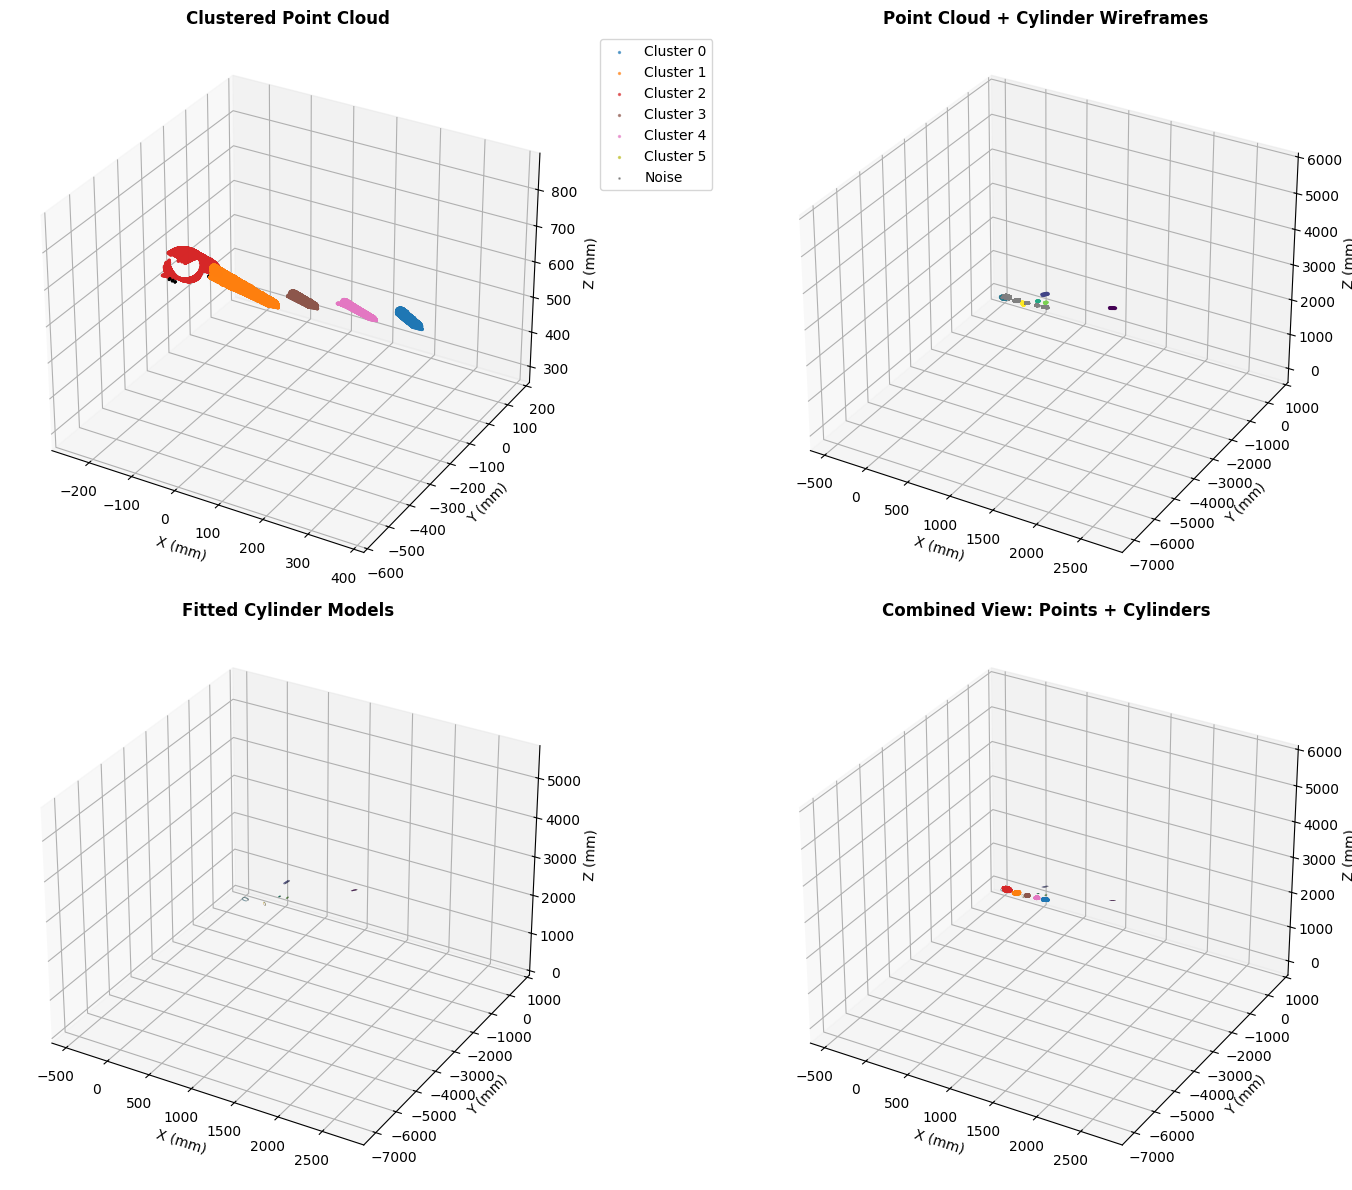

Creating individual cylinder details...


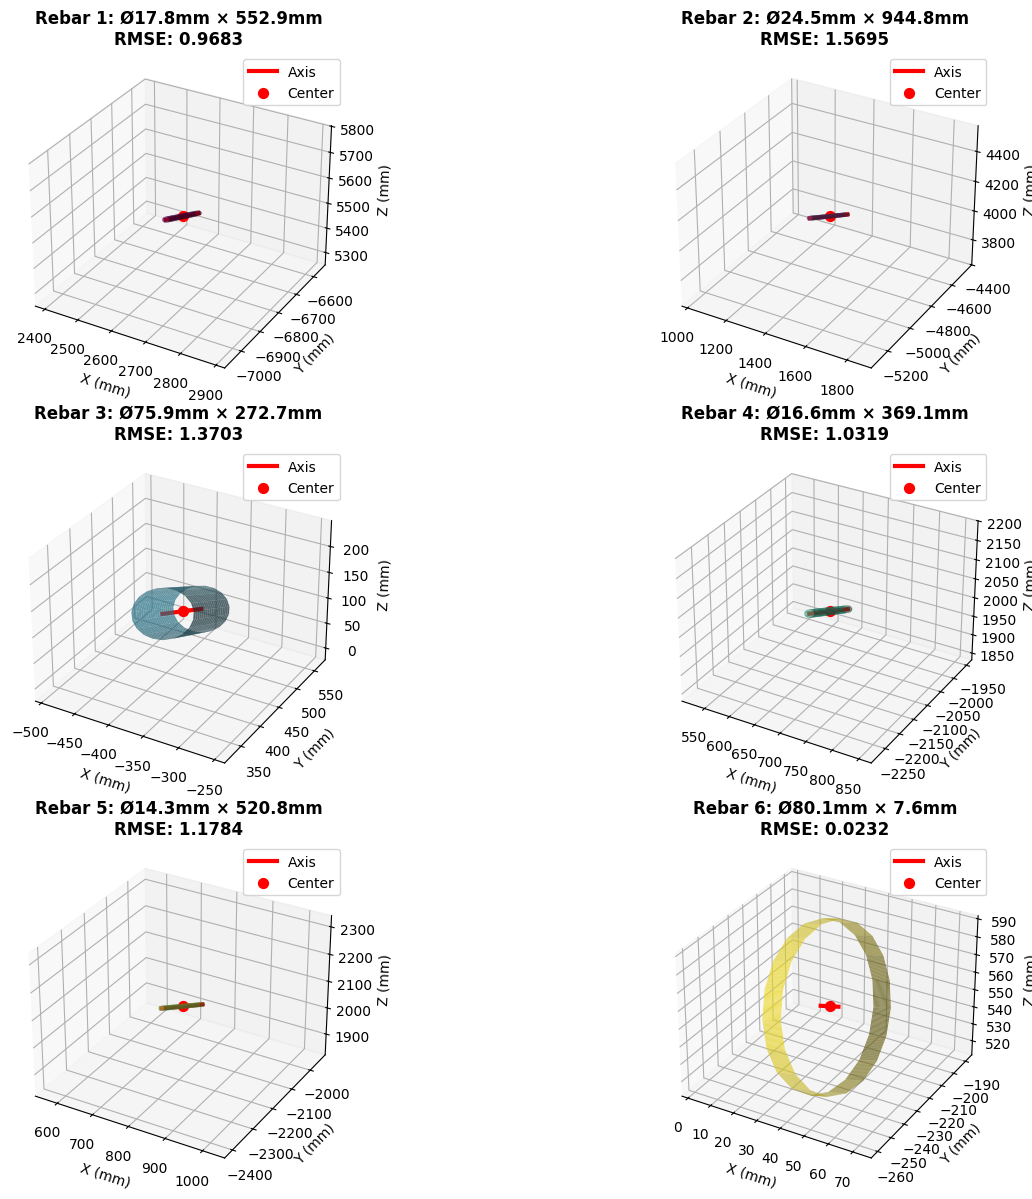

Generating sectional analysis plots...


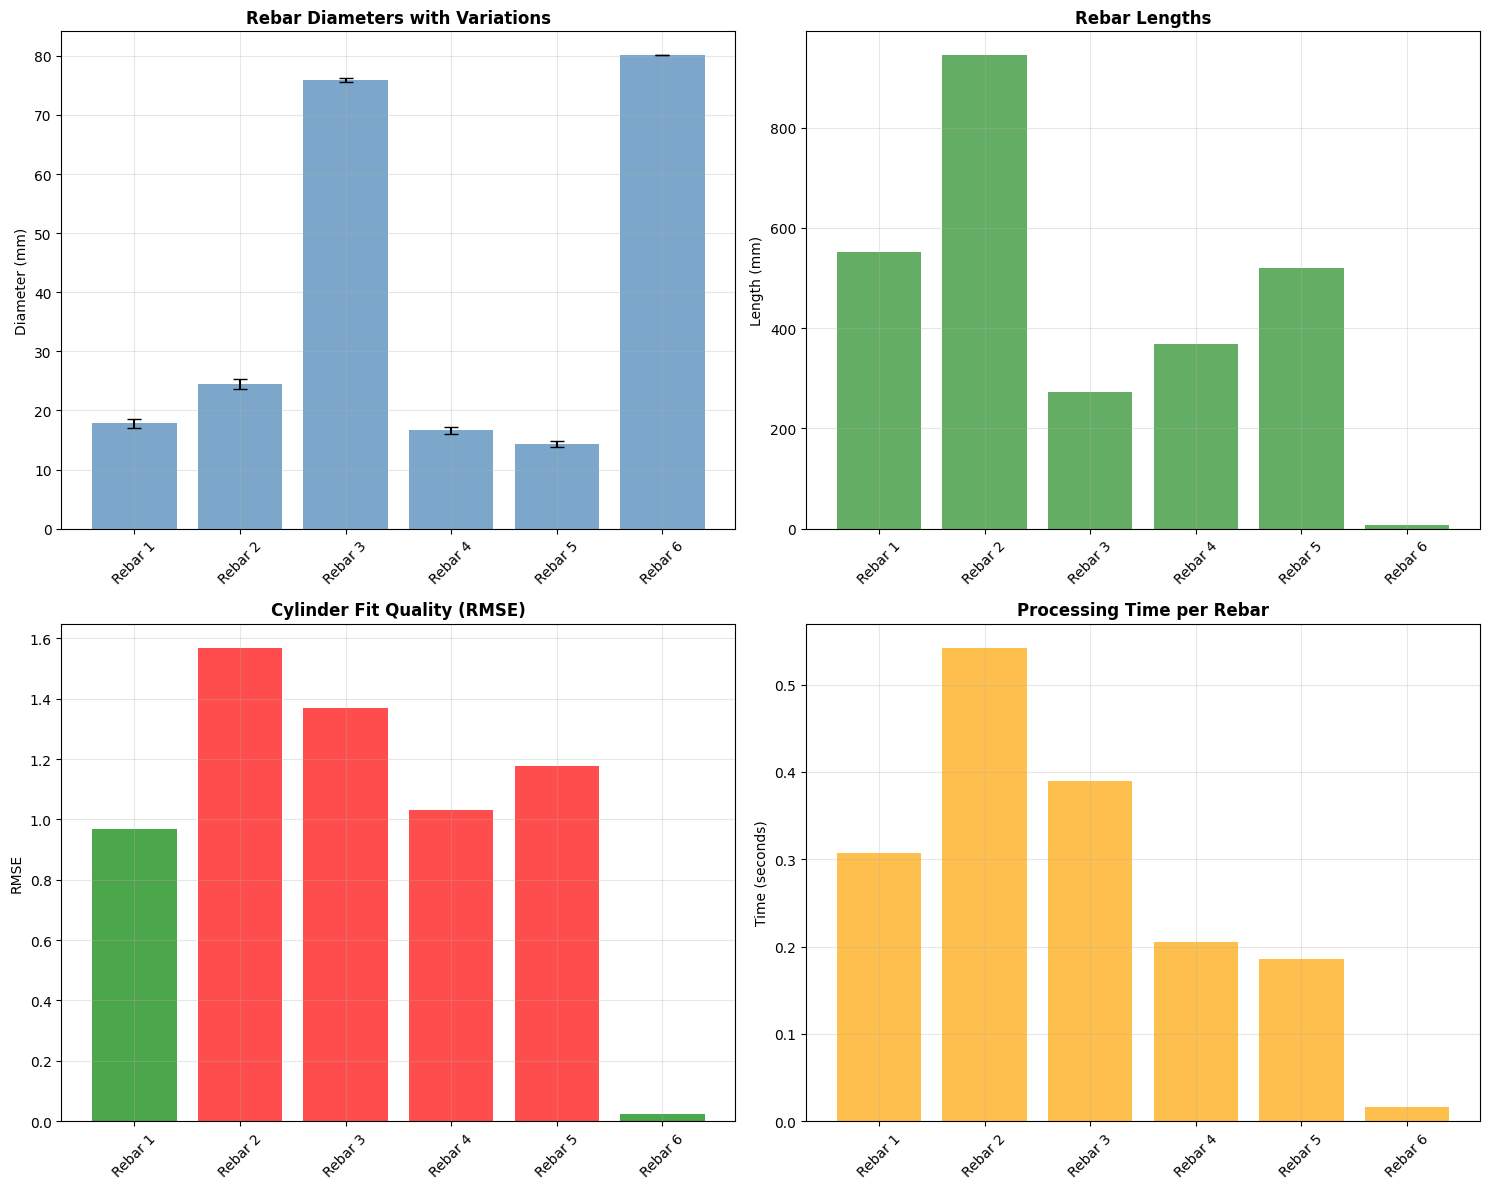

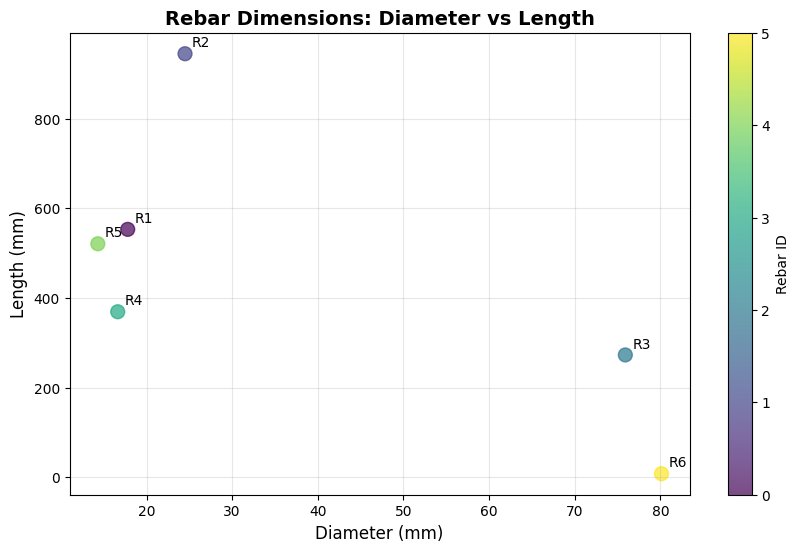

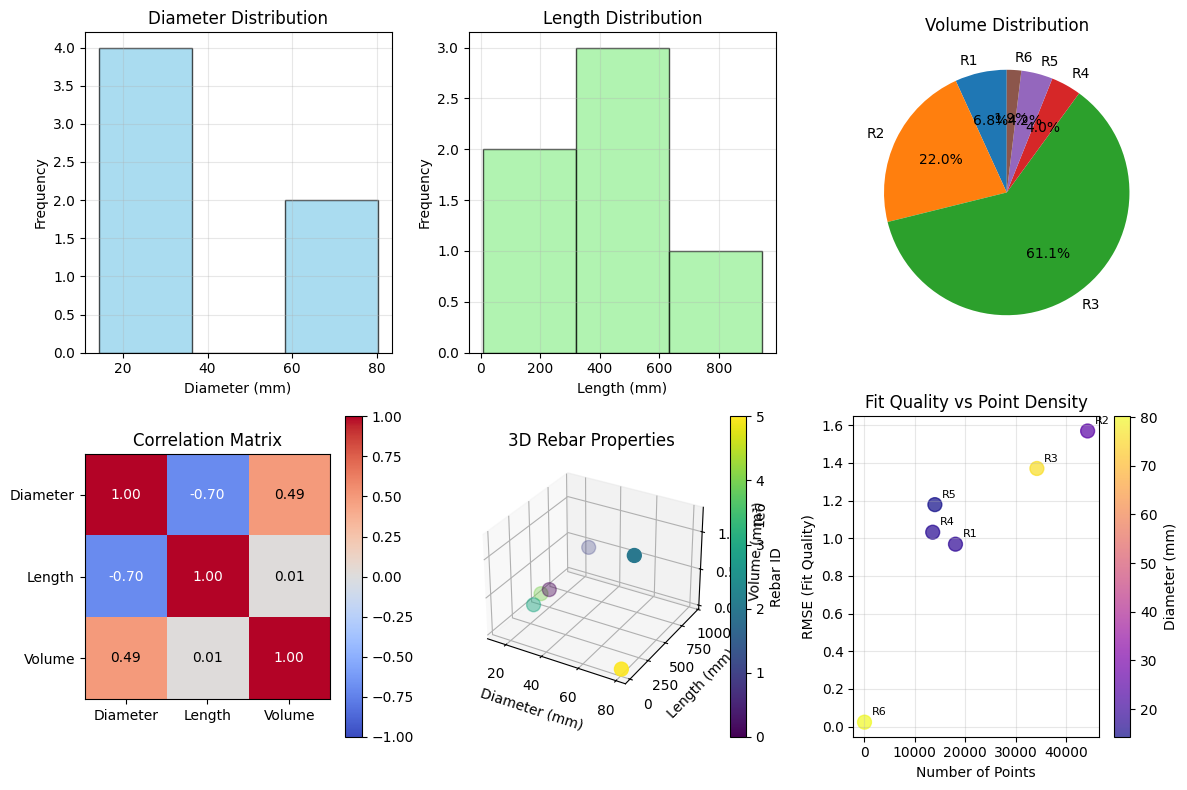

All visualizations completed!


In [2]:
import open3d as o3d
import numpy as np
from scipy.optimize import least_squares
import time
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import warnings
warnings.filterwarnings('ignore')

def create_cylinder_surface(center, axis, radius, length, resolution=20):
    """Create cylinder surface points for matplotlib visualization"""
    # Create parameter space
    theta = np.linspace(0, 2*np.pi, resolution)
    z = np.linspace(-length/2, length/2, resolution)
    theta_mesh, z_mesh = np.meshgrid(theta, z)
    
    # Create cylinder in local coordinates
    x_local = radius * np.cos(theta_mesh)
    y_local = radius * np.sin(theta_mesh)
    z_local = z_mesh
    
    # Convert to global coordinates
    # Create orthonormal basis with axis as one vector
    axis = axis / np.linalg.norm(axis)
    if abs(axis[0]) < 0.9:
        v1 = np.cross(axis, [1, 0, 0])
    else:
        v1 = np.cross(axis, [0, 1, 0])
    v1 = v1 / np.linalg.norm(v1)
    v2 = np.cross(axis, v1)
    
    # Transform points
    points = np.zeros((resolution, resolution, 3))
    for i in range(resolution):
        for j in range(resolution):
            local_point = np.array([x_local[i,j], y_local[i,j], z_local[i,j]])
            global_point = (local_point[0] * v1 + 
                          local_point[1] * v2 + 
                          local_point[2] * axis + 
                          center)
            points[i,j] = global_point
    
    return points[:,:,0], points[:,:,1], points[:,:,2]

def create_cylinder_wireframe_data(center, axis, radius, length, num_circles=8, points_per_circle=16):
    """Create wireframe data for cylinder visualization"""
    wireframe_points = []
    
    # Create circles along the cylinder axis
    for i in range(num_circles):
        t = (i / (num_circles - 1) - 0.5) * length
        circle_center = center + t * axis
        
        # Create orthonormal basis
        axis_norm = axis / np.linalg.norm(axis)
        if abs(axis_norm[0]) < 0.9:
            v1 = np.cross(axis_norm, [1, 0, 0])
        else:
            v1 = np.cross(axis_norm, [0, 1, 0])
        v1 = v1 / np.linalg.norm(v1)
        v2 = np.cross(axis_norm, v1)
        
        circle_points = []
        for j in range(points_per_circle):
            angle = 2 * np.pi * j / points_per_circle
            point = circle_center + radius * (np.cos(angle) * v1 + np.sin(angle) * v2)
            circle_points.append(point)
        
        wireframe_points.append(circle_points)
    
    return wireframe_points

def plot_3d_point_cloud_with_cylinders(points, labels, cylinder_results, figure_size=(15, 12)):
    """Create comprehensive 3D visualization using matplotlib"""
    
    # Create figure with subplots
    fig = plt.figure(figsize=figure_size)
    
    # Plot 1: Point cloud with clusters
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    
    # Color points by cluster
    unique_labels = set(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        if label == -1:
            # Noise points in black
            mask = labels == label
            ax1.scatter(points[mask, 0], points[mask, 1], points[mask, 2], 
                       c='black', s=1, alpha=0.3, label='Noise')
        else:
            mask = labels == label
            ax1.scatter(points[mask, 0], points[mask, 1], points[mask, 2], 
                       c=[colors[i]], s=2, alpha=0.6, label=f'Cluster {label}')
    
    ax1.set_title('Clustered Point Cloud', fontweight='bold')
    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    ax1.set_zlabel('Z (mm)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: Point cloud with fitted cylinder wireframes
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    
    # Plot points in gray
    ax2.scatter(points[:, 0], points[:, 1], points[:, 2], 
               c='gray', s=1, alpha=0.3, label='Point Cloud')
    
    # Plot cylinder wireframes
    colors_cylinders = plt.cm.viridis(np.linspace(0, 1, len(cylinder_results)))
    
    for i, result in enumerate(cylinder_results):
        wireframe_data = create_cylinder_wireframe_data(
            result['center'], result['axis'], result['radius'], result['length']
        )
        
        # Plot circles
        for circle in wireframe_data:
            circle_array = np.array(circle + [circle[0]])  # Close the circle
            ax2.plot(circle_array[:, 0], circle_array[:, 1], circle_array[:, 2], 
                    color=colors_cylinders[i], linewidth=2, alpha=0.8)
        
        # Plot connecting lines
        for j in range(len(wireframe_data[0])):
            line_points = [circle[j] for circle in wireframe_data]
            line_array = np.array(line_points)
            ax2.plot(line_array[:, 0], line_array[:, 1], line_array[:, 2], 
                    color=colors_cylinders[i], linewidth=1, alpha=0.6)
    
    ax2.set_title('Point Cloud + Cylinder Wireframes', fontweight='bold')
    ax2.set_xlabel('X (mm)')
    ax2.set_ylabel('Y (mm)')
    ax2.set_zlabel('Z (mm)')
    
    # Plot 3: Fitted cylinder surfaces
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    
    for i, result in enumerate(cylinder_results):
        x_surf, y_surf, z_surf = create_cylinder_surface(
            result['center'], result['axis'], result['radius'], result['length']
        )
        
        ax3.plot_surface(x_surf, y_surf, z_surf, 
                        color=colors_cylinders[i], alpha=0.7, 
                        label=f"Rebar {result['id']}")
    
    ax3.set_title('Fitted Cylinder Models', fontweight='bold')
    ax3.set_xlabel('X (mm)')
    ax3.set_ylabel('Y (mm)')
    ax3.set_zlabel('Z (mm)')
    
    # Plot 4: Combined view with transparency
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    
    # Sample points for better visualization
    sample_size = min(5000, len(points))
    sample_indices = np.random.choice(len(points), sample_size, replace=False)
    sample_points = points[sample_indices]
    sample_labels = labels[sample_indices]
    
    # Plot sampled points
    for i, label in enumerate(set(sample_labels)):
        if label == -1:
            continue
        mask = sample_labels == label
        ax4.scatter(sample_points[mask, 0], sample_points[mask, 1], sample_points[mask, 2], 
                   c=[colors[i]], s=3, alpha=0.4)
    
    # Plot cylinder surfaces with higher transparency
    for i, result in enumerate(cylinder_results):
        x_surf, y_surf, z_surf = create_cylinder_surface(
            result['center'], result['axis'], result['radius'], result['length']
        )
        ax4.plot_surface(x_surf, y_surf, z_surf, 
                        color=colors_cylinders[i], alpha=0.5)
    
    ax4.set_title('Combined View: Points + Cylinders', fontweight='bold')
    ax4.set_xlabel('X (mm)')
    ax4.set_ylabel('Y (mm)')
    ax4.set_zlabel('Z (mm)')
    
    plt.tight_layout()
    plt.show()

def plot_cylinder_details(cylinder_results):
    """Create detailed plots for individual cylinders"""
    n_cylinders = len(cylinder_results)
    if n_cylinders == 0:
        return
    
    # Create figure for individual cylinder details
    fig = plt.figure(figsize=(16, 4 * ((n_cylinders + 1) // 2)))
    
    for i, result in enumerate(cylinder_results):
        ax = fig.add_subplot((n_cylinders + 1) // 2, 2, i + 1, projection='3d')
        
        # Plot cylinder surface
        x_surf, y_surf, z_surf = create_cylinder_surface(
            result['center'], result['axis'], result['radius'], result['length']
        )
        
        color = plt.cm.viridis(i / max(1, n_cylinders - 1))
        ax.plot_surface(x_surf, y_surf, z_surf, color=color, alpha=0.7)
        
        # Add axis line
        axis_start = result['center'] - result['axis'] * result['length'] / 2
        axis_end = result['center'] + result['axis'] * result['length'] / 2
        ax.plot([axis_start[0], axis_end[0]], 
               [axis_start[1], axis_end[1]], 
               [axis_start[2], axis_end[2]], 
               'r-', linewidth=3, label='Axis')
        
        # Add center point
        ax.scatter(*result['center'], c='red', s=50, label='Center')
        
        ax.set_title(f"Rebar {result['id']}: Ø{result['diameter']:.1f}mm × {result['length']:.1f}mm\n"
                    f"RMSE: {result['rmse']:.4f}", fontweight='bold')
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_zlabel('Z (mm)')
        ax.legend()
        
        # Set equal aspect ratio
        center = result['center']
        max_range = max(result['radius'] * 2, result['length']) / 2
        ax.set_xlim(center[0] - max_range, center[0] + max_range)
        ax.set_ylim(center[1] - max_range, center[1] + max_range)
        ax.set_zlim(center[2] - max_range, center[2] + max_range)
    
    plt.tight_layout()
    plt.show()

def visualize_sectional_analysis(cylinder_results):
    """Create plots for sectional analysis"""
    n_cylinders = len(cylinder_results)
    if n_cylinders == 0:
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Diameter comparison
    cylinder_ids = [f"Rebar {c['id']}" for c in cylinder_results]
    diameters = [c['diameter'] for c in cylinder_results]
    diameter_stds = [c['diameter_std'] for c in cylinder_results]
    
    axes[0,0].bar(cylinder_ids, diameters, yerr=diameter_stds, capsize=5, alpha=0.7, color='steelblue')
    axes[0,0].set_title('Rebar Diameters with Variations', fontsize=12, fontweight='bold')
    axes[0,0].set_ylabel('Diameter (mm)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Length comparison
    lengths = [c['length'] for c in cylinder_results]
    axes[0,1].bar(cylinder_ids, lengths, alpha=0.7, color='forestgreen')
    axes[0,1].set_title('Rebar Lengths', fontsize=12, fontweight='bold')
    axes[0,1].set_ylabel('Length (mm)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: RMSE (fit quality)
    rmse_values = [c['rmse'] for c in cylinder_results]
    colors = ['red' if rmse > np.mean(rmse_values) else 'green' for rmse in rmse_values]
    axes[1,0].bar(cylinder_ids, rmse_values, alpha=0.7, color=colors)
    axes[1,0].set_title('Cylinder Fit Quality (RMSE)', fontsize=12, fontweight='bold')
    axes[1,0].set_ylabel('RMSE')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Processing time
    processing_times = [c['fitting_time'] + c['analysis_time'] for c in cylinder_results]
    axes[1,1].bar(cylinder_ids, processing_times, alpha=0.7, color='orange')
    axes[1,1].set_title('Processing Time per Rebar', fontsize=12, fontweight='bold')
    axes[1,1].set_ylabel('Time (seconds)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Diameter vs Length scatter
    plt.figure(figsize=(10, 6))
    plt.scatter(diameters, lengths, s=100, alpha=0.7, c=range(len(diameters)), cmap='viridis')
    plt.xlabel('Diameter (mm)', fontsize=12)
    plt.ylabel('Length (mm)', fontsize=12)
    plt.title('Rebar Dimensions: Diameter vs Length', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add labels for each point
    for i, (d, l) in enumerate(zip(diameters, lengths)):
        plt.annotate(f'R{i+1}', (d, l), xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.colorbar(label='Rebar ID')
    plt.show()

def basic_cylinder_fitting_analysis():
    """Perform cylinder fitting and sectional analysis on clustered rebars"""
    
    # Load point cloud
    file_path = r"C:\open3d-env\rebar\pcd20250808\0807_15.ply"
    pcd = o3d.io.read_point_cloud(file_path)
    pcd_clean, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    points = np.asarray(pcd_clean.points)
    
    print(f"Starting analysis on {len(points)} points...")
    
    # Use optimal clustering parameters found
    eps = 8.326386
    min_samples = 50
    
    total_start_time = time.time()
    
    # Clustering
    cluster_start = time.time()
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    cluster_time = time.time() - cluster_start
    
    # Get clusters
    clusters = []
    for label in set(labels):
        if label != -1:  # Ignore noise
            cluster_points = points[labels == label]
            clusters.append(cluster_points)
    
    print(f"Clustering completed in {cluster_time:.3f}s - Found {len(clusters)} clusters")
    
    # Initialize results storage
    cylinder_results = []
    total_fitting_time = 0
    total_analysis_time = 0
    
    # Process each cluster
    for i, cluster_points in enumerate(clusters):
        print(f"\nProcessing Cylinder {i+1}/{len(clusters)} ({len(cluster_points)} points)...")
        
        # CYLINDER FITTING
        fitting_start = time.time()
        
        # Initial cylinder estimation using PCA
        pca = PCA(n_components=3)
        pca.fit(cluster_points)
        
        # Cylinder axis is the first principal component (longest dimension)
        axis = pca.components_[0]
        center = np.mean(cluster_points, axis=0)
        
        # Calculate radius by projecting points to plane perpendicular to axis
        relative_points = cluster_points - center
        projections_along_axis = np.dot(relative_points, axis)
        projected_on_axis = np.outer(projections_along_axis, axis)
        perpendicular_distances = relative_points - projected_on_axis
        distances_to_axis = np.linalg.norm(perpendicular_distances, axis=1)
        radius = np.mean(distances_to_axis)
        
        # Least squares refinement
        def cylinder_residuals(params, points):
            cx, cy, cz, ax, ay, az, r = params
            center_pt = np.array([cx, cy, cz])
            axis_vec = np.array([ax, ay, az])
            axis_vec = axis_vec / np.linalg.norm(axis_vec)
            
            # Distance from points to cylinder axis
            to_center = points - center_pt
            proj_lengths = np.dot(to_center, axis_vec)
            projections = np.outer(proj_lengths, axis_vec)
            perpendicular = to_center - projections
            distances = np.linalg.norm(perpendicular, axis=1)
            
            return distances - r
        
        initial_params = [center[0], center[1], center[2], axis[0], axis[1], axis[2], radius]
        result = least_squares(cylinder_residuals, initial_params, args=(cluster_points,))
        
        # Extract refined parameters
        refined_center = result.x[:3]
        refined_axis = result.x[3:6] / np.linalg.norm(result.x[3:6])
        refined_radius = result.x[6]
        rmse = np.sqrt(np.mean(result.fun**2))
        
        fitting_time = time.time() - fitting_start
        total_fitting_time += fitting_time
        
        # SECTIONAL ANALYSIS
        analysis_start = time.time()
        
        # Calculate cylinder length
        projections = np.dot(cluster_points - refined_center, refined_axis)
        length = np.max(projections) - np.min(projections)
        
        # Sectional diameter analysis (10 sections)
        num_sections = 10
        section_boundaries = np.linspace(np.min(projections), np.max(projections), num_sections + 1)
        section_diameters = []
        
        for j in range(num_sections):
            mask = (projections >= section_boundaries[j]) & (projections < section_boundaries[j+1])
            if np.sum(mask) < 5:  # Skip if too few points
                continue
                
            section_points = cluster_points[mask]
            section_center = refined_center + refined_axis * ((section_boundaries[j] + section_boundaries[j+1]) / 2)
            
            # Calculate diameter in this section
            relative = section_points - section_center
            perpendicular = relative - np.outer(np.dot(relative, refined_axis), refined_axis)
            section_distances = np.linalg.norm(perpendicular, axis=1)
            section_diameter = 2 * np.mean(section_distances)
            section_diameters.append(section_diameter)
        
        avg_diameter = np.mean(section_diameters) if section_diameters else 2 * refined_radius
        diameter_std = np.std(section_diameters) if len(section_diameters) > 1 else 0
        
        analysis_time = time.time() - analysis_start
        total_analysis_time += analysis_time
        
        # Store results
        result_data = {
            'id': i + 1,
            'center': refined_center,
            'axis': refined_axis,
            'radius': refined_radius,
            'diameter': 2 * refined_radius,
            'length': length,
            'avg_diameter': avg_diameter,
            'diameter_std': diameter_std,
            'rmse': rmse,
            'num_points': len(cluster_points),
            'fitting_time': fitting_time,
            'analysis_time': analysis_time
        }
        
        cylinder_results.append(result_data)
        
        # Print individual results
        print(f"  Diameter: {result_data['diameter']:.2f} mm (±{diameter_std:.2f})")
        print(f"  Length: {length:.2f} mm")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  Processing time: {fitting_time + analysis_time:.3f}s")
    
    total_time = time.time() - total_start_time
    
    # COMPUTATIONAL COST ANALYSIS
    print("\n" + "="*60)
    print("CYLINDER FITTING & SECTIONAL ANALYSIS RESULTS")
    print("="*60)
    
    if cylinder_results:
        diameters = [c['diameter'] for c in cylinder_results]
        lengths = [c['length'] for c in cylinder_results]
        
        print(f"\nDIMENSIONAL SUMMARY:")
        print(f"  Rebars detected: {len(cylinder_results)}")
        print(f"  Average diameter: {np.mean(diameters):.2f} ± {np.std(diameters):.2f} mm")
        print(f"  Diameter range: {np.min(diameters):.2f} - {np.max(diameters):.2f} mm")
        print(f"  Average length: {np.mean(lengths):.2f} ± {np.std(lengths):.2f} mm")
        print(f"  Length range: {np.min(lengths):.2f} - {np.max(lengths):.2f} mm")
        
        print(f"\nINDIVIDUAL REBAR DIMENSIONS:")
        for cyl in cylinder_results:
            print(f"  Rebar {cyl['id']}: Ø{cyl['diameter']:.1f}mm × {cyl['length']:.1f}mm "
                  f"(±{cyl['diameter_std']:.2f}mm variation)")
    
    # Time and cost breakdown
    processing_cost_per_second = 0.015  # $0.015 per second
    
    print(f"\nCOMPUTATION PERFORMANCE:")
    print(f"  Clustering time: {cluster_time:.3f}s")
    print(f"  Total fitting time: {total_fitting_time:.3f}s")
    print(f"  Total sectional analysis: {total_analysis_time:.3f}s")
    print(f"  Total processing time: {total_time:.3f}s")
    print(f"  Average time per cylinder: {total_time/len(cylinder_results):.3f}s")
    
    print(f"\nCOMPUTATION COST BREAKDOWN:")
    print(f"  Clustering cost: ${cluster_time * processing_cost_per_second:.4f}")
    print(f"  Fitting cost: ${total_fitting_time * processing_cost_per_second:.4f}")
    print(f"  Analysis cost: ${total_analysis_time * processing_cost_per_second:.4f}")
    print(f"  TOTAL COST: ${total_time * processing_cost_per_second:.4f}")
    
    print(f"\nPROCESSING EFFICIENCY:")
    print(f"  Points per second: {len(points)/total_time:.0f}")
    print(f"  Cost per rebar: ${(total_time * processing_cost_per_second)/len(cylinder_results):.4f}")
    print(f"  Cost per 1000 points: ${(total_time * processing_cost_per_second)/(len(points)/1000):.4f}")
    
    print("="*60)
    
    # JUPYTER NOTEBOOK VISUALIZATIONS
    print("\nGenerating visualizations for Jupyter notebook...")
    
    # 1. Main 3D visualization with multiple views
    print("Creating main 3D visualization...")
    plot_3d_point_cloud_with_cylinders(points, labels, cylinder_results)
    
    # 2. Individual cylinder details
    print("Creating individual cylinder details...")
    plot_cylinder_details(cylinder_results)
    
    # 3. Sectional analysis plots
    print("Generating sectional analysis plots...")
    visualize_sectional_analysis(cylinder_results)
    
    # 4. Create summary statistics plot
    if cylinder_results:
        plt.figure(figsize=(12, 8))
        
        # Create summary statistics
        diameters = [c['diameter'] for c in cylinder_results]
        lengths = [c['length'] for c in cylinder_results]
        volumes = [np.pi * (c['radius']**2) * c['length'] for c in cylinder_results]
        
        # Subplot 1: Histogram of diameters
        plt.subplot(2, 3, 1)
        plt.hist(diameters, bins=max(3, len(diameters)//2), alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Diameter Distribution')
        plt.xlabel('Diameter (mm)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Histogram of lengths
        plt.subplot(2, 3, 2)
        plt.hist(lengths, bins=max(3, len(lengths)//2), alpha=0.7, color='lightgreen', edgecolor='black')
        plt.title('Length Distribution')
        plt.xlabel('Length (mm)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Subplot 3: Volume comparison
        plt.subplot(2, 3, 3)
        rebar_labels = [f'R{i+1}' for i in range(len(volumes))]
        plt.pie(volumes, labels=rebar_labels, autopct='%1.1f%%', startangle=90)
        plt.title('Volume Distribution')
        
        # Subplot 4: Correlation matrix
        plt.subplot(2, 3, 4)
        data_matrix = np.array([diameters, lengths, volumes])
        correlation_matrix = np.corrcoef(data_matrix)
        im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar(im)
        plt.title('Correlation Matrix')
        plt.xticks([0, 1, 2], ['Diameter', 'Length', 'Volume'])
        plt.yticks([0, 1, 2], ['Diameter', 'Length', 'Volume'])
        
        # Add correlation values
        for i in range(3):
            for j in range(3):
                plt.text(j, i, f'{correlation_matrix[i,j]:.2f}', 
                        ha='center', va='center', color='white' if abs(correlation_matrix[i,j]) > 0.5 else 'black')
        
        # Subplot 5: 3D scatter plot
        ax = plt.subplot(2, 3, 5, projection='3d')
        scatter = ax.scatter(diameters, lengths, volumes, c=range(len(diameters)), cmap='viridis', s=100)
        ax.set_xlabel('Diameter (mm)')
        ax.set_ylabel('Length (mm)')
        ax.set_zlabel('Volume (mm³)')
        ax.set_title('3D Rebar Properties')
        plt.colorbar(scatter, ax=ax, label='Rebar ID')
        
        # Subplot 6: Quality metrics
        plt.subplot(2, 3, 6)
        rmse_values = [c['rmse'] for c in cylinder_results]
        point_counts = [c['num_points'] for c in cylinder_results]
        
        scatter = plt.scatter(point_counts, rmse_values, c=diameters, cmap='plasma', s=100, alpha=0.7)
        plt.xlabel('Number of Points')
        plt.ylabel('RMSE (Fit Quality)')
        plt.title('Fit Quality vs Point Density')
        plt.colorbar(scatter, label='Diameter (mm)')
        plt.grid(True, alpha=0.3)
        
        # Add labels
        for i, (x, y) in enumerate(zip(point_counts, rmse_values)):
            plt.annotate(f'R{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    print("All visualizations completed!")
    
    return cylinder_results

# Run the analysis
if __name__ == "__main__":
    results = basic_cylinder_fitting_analysis()

# Basic Sectional Analysis

Starting sectional analysis on 124241 points...
Clustering completed in 3.154s - Found 6 clusters

Processing Cylinder 1/6 (18077 points)...
  Diameter (avg over slices): 13.42 mm (±1.40)
  Length: 552.89 mm
  RMSE (slice residuals): 2.5734
  Processing time: 0.005s

Processing Cylinder 2/6 (44248 points)...
  Diameter (avg over slices): 19.12 mm (±1.80)
  Length: 944.74 mm
  RMSE (slice residuals): 3.5805
  Processing time: 0.009s

Processing Cylinder 3/6 (34202 points)...
  Diameter (avg over slices): 55.84 mm (±12.37)
  Length: 280.58 mm
  RMSE (slice residuals): 8.3744
  Processing time: 0.008s

Processing Cylinder 4/6 (13564 points)...
  Diameter (avg over slices): 14.52 mm (±0.64)
  Length: 369.06 mm
  RMSE (slice residuals): 2.1573
  Processing time: 0.004s

Processing Cylinder 5/6 (13994 points)...
  Diameter (avg over slices): 11.47 mm (±1.25)
  Length: 520.80 mm
  RMSE (slice residuals): 2.0313
  Processing time: 0.004s

Processing Cylinder 6/6 (54 points)...
  Diameter (avg 

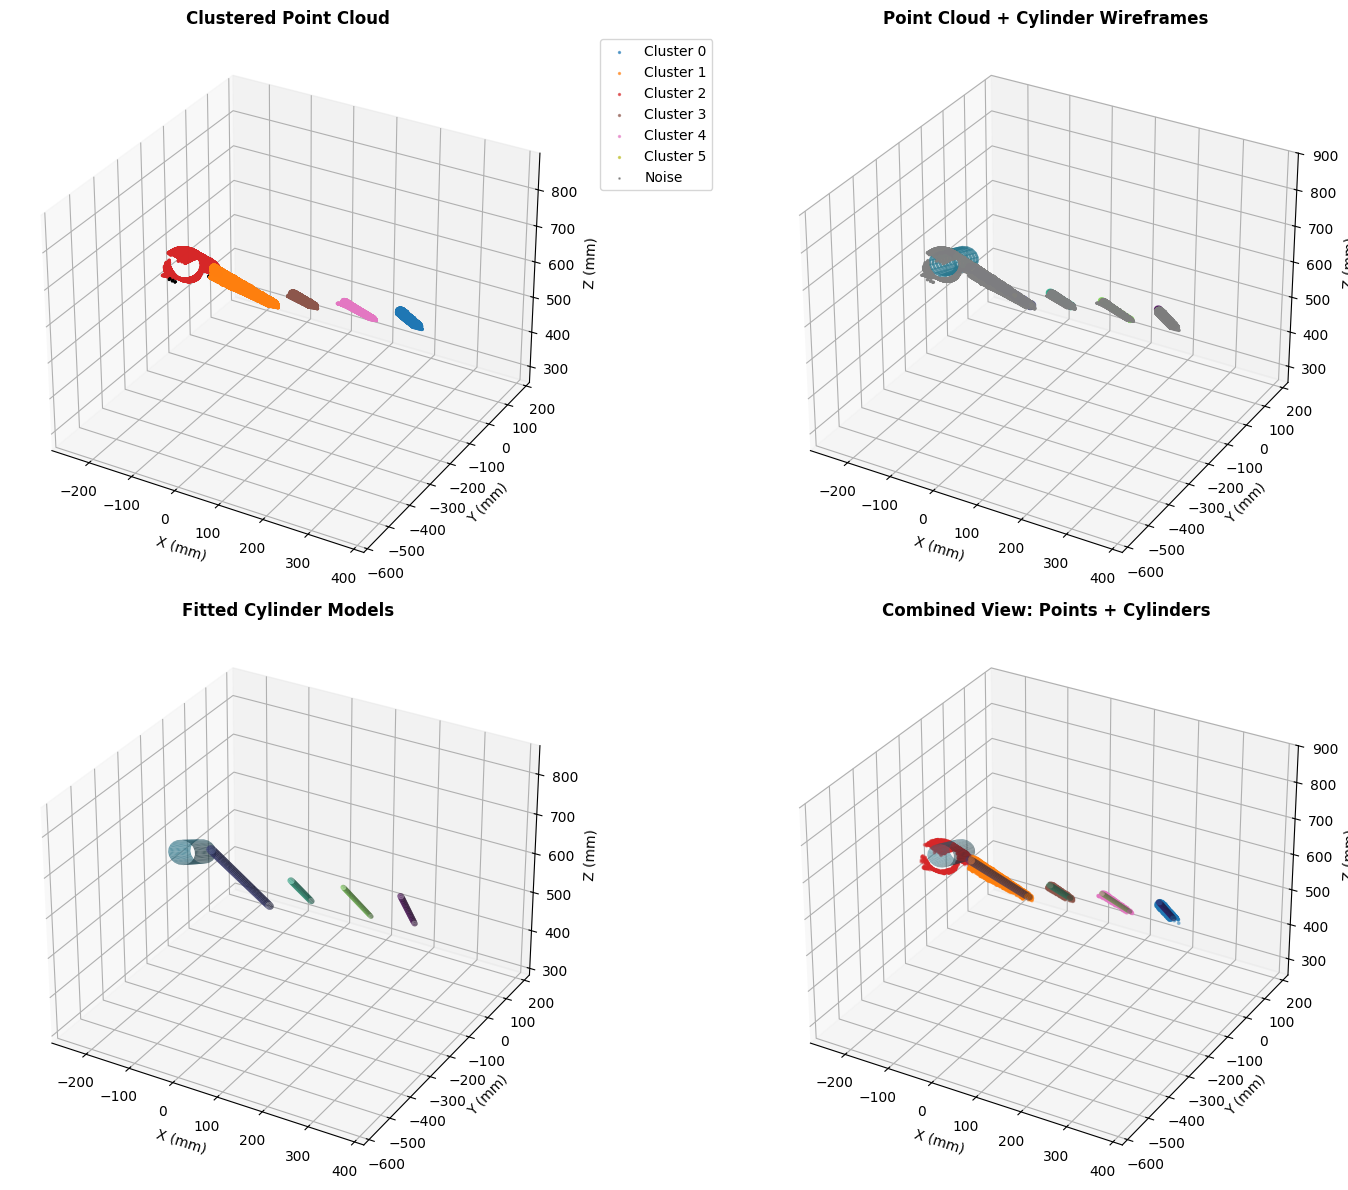

Creating individual cylinder details...


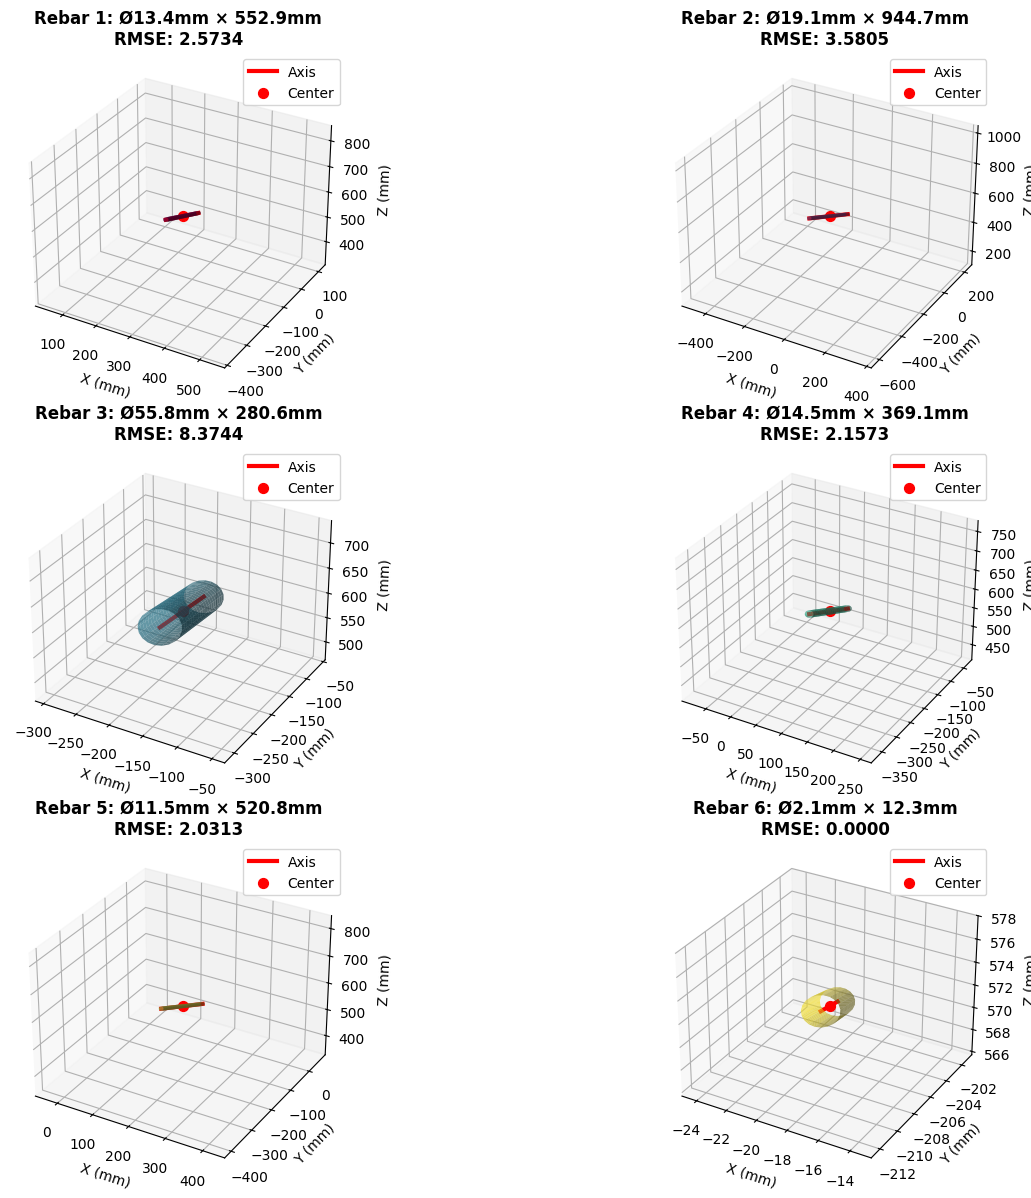

Generating sectional analysis plots...


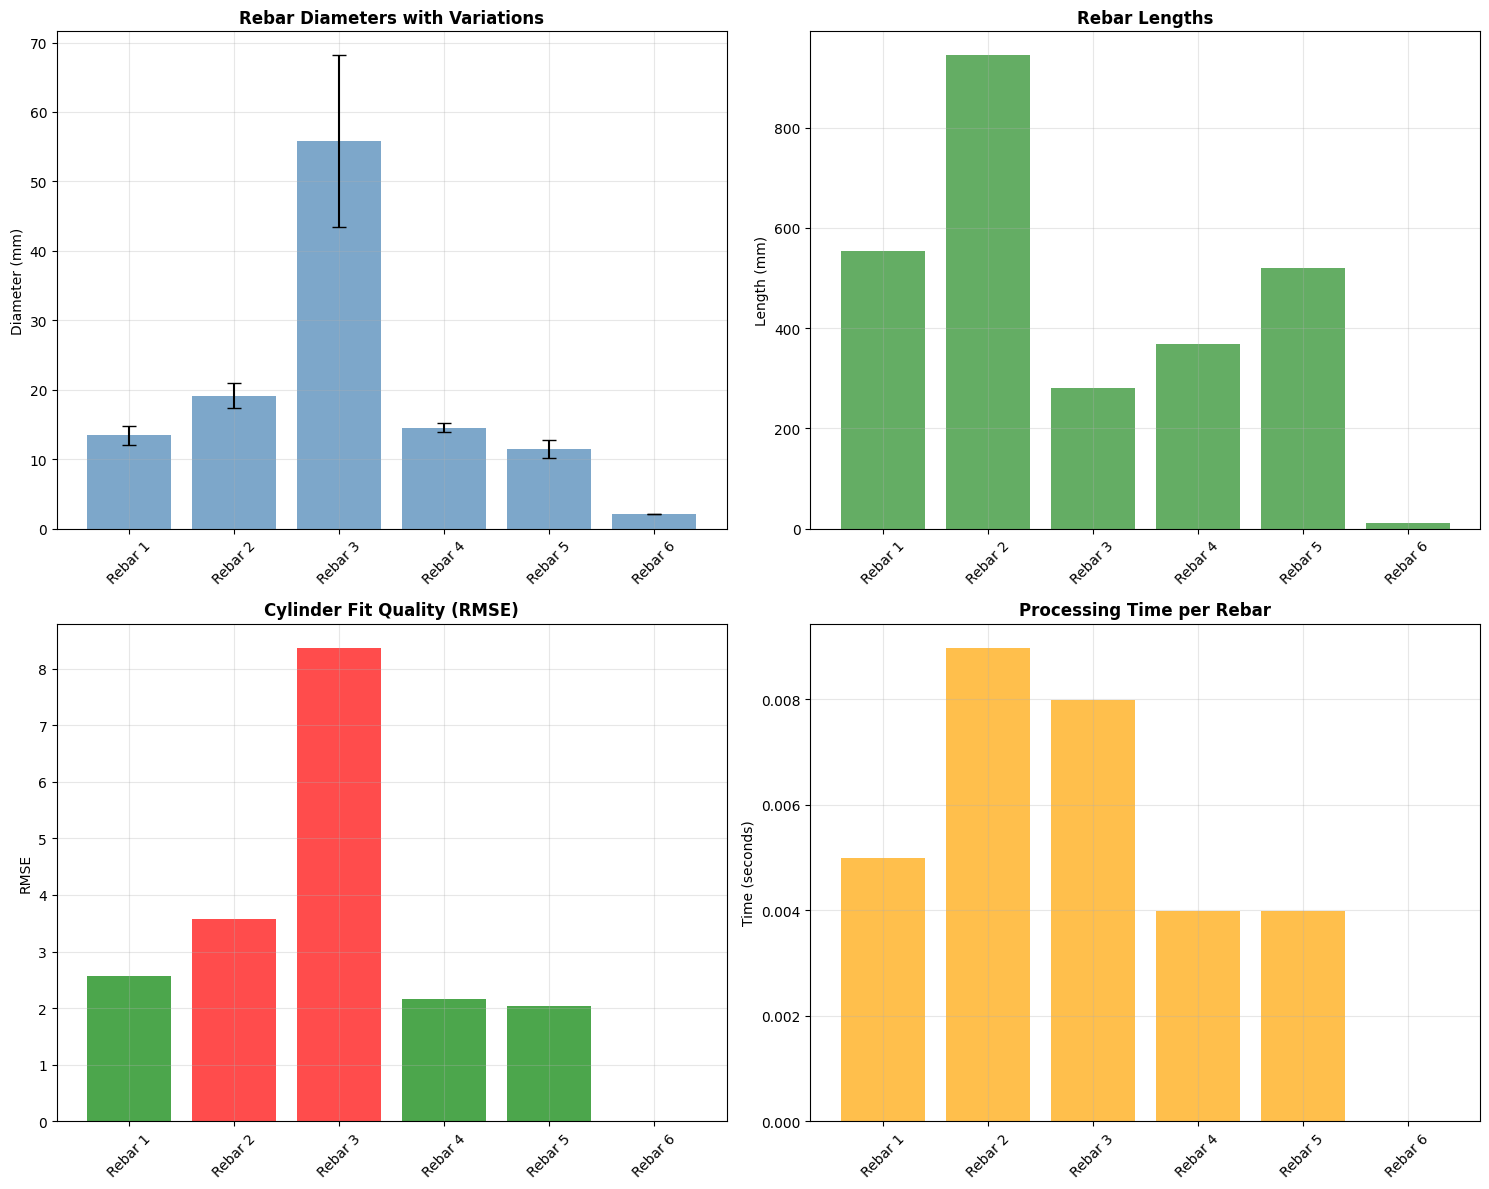

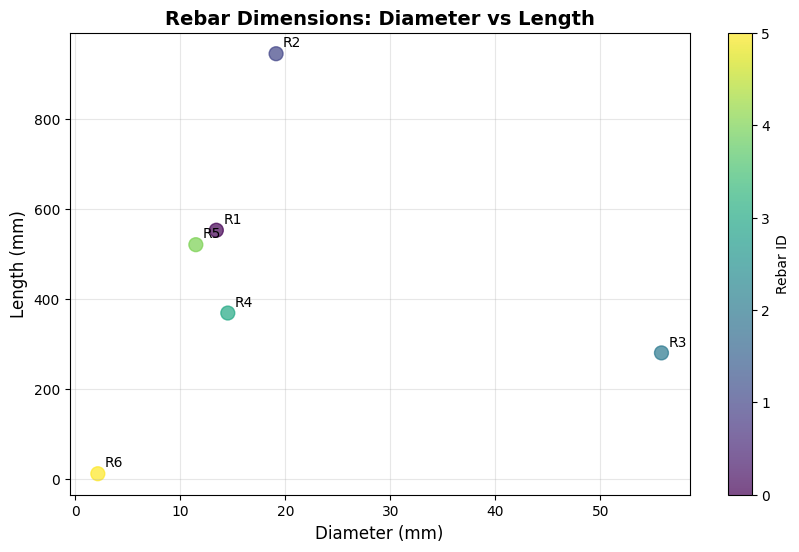

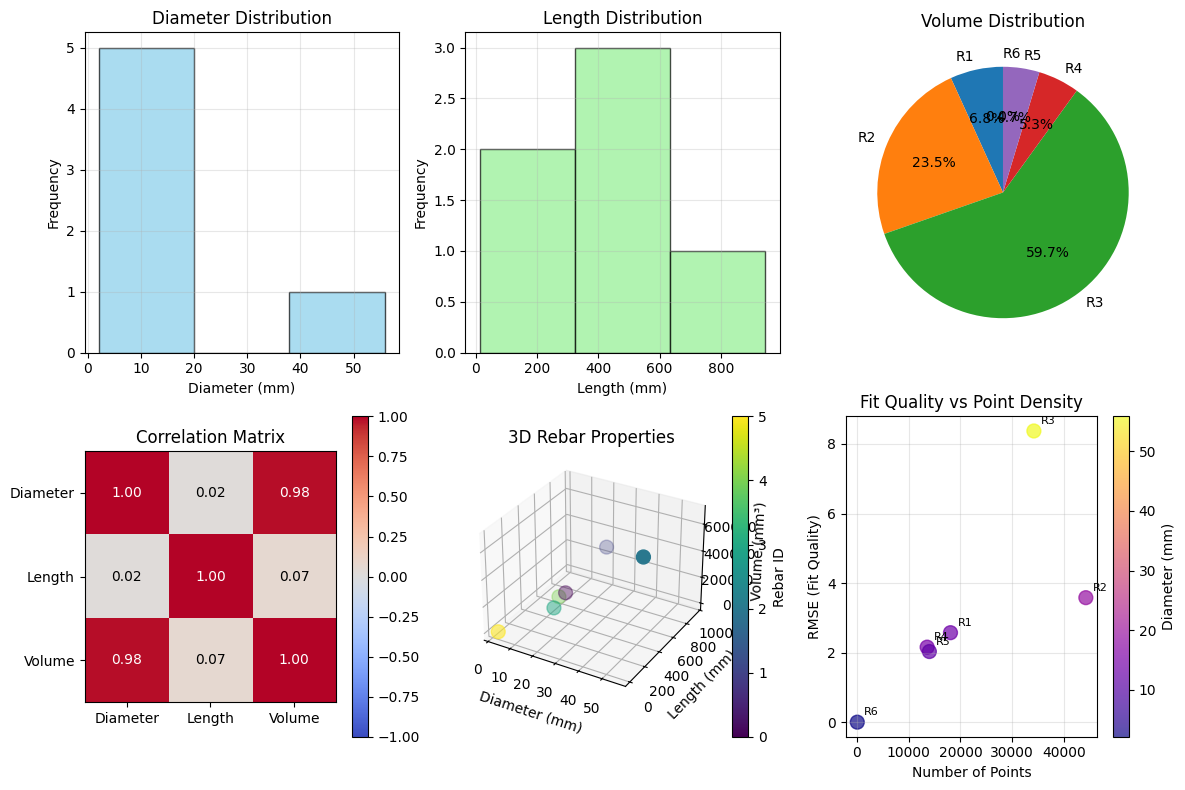

All visualizations completed!


In [4]:
def rebar_sectional_analysis():
    """Perform sectional analysis (no global cylinder least-squares) on clustered rebars"""
    # Load point cloud
    file_path = r"C:\open3d-env\rebar\pcd20250808\0807_15.ply"
    pcd = o3d.io.read_point_cloud(file_path)
    pcd_clean, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    points = np.asarray(pcd_clean.points)

    print(f"Starting sectional analysis on {len(points)} points...")

    # Use your existing clustering settings
    eps = 8.326386
    min_samples = 50

    total_start_time = time.time()

    # Clustering
    cluster_start = time.time()
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    cluster_time = time.time() - cluster_start

    # Collect clusters (ignore noise)
    clusters = []
    for label in set(labels):
        if label != -1:
            clusters.append(points[labels == label])

    print(f"Clustering completed in {cluster_time:.3f}s - Found {len(clusters)} clusters")

    # Results containers
    cylinder_results = []
    total_fitting_time = 0.0     # kept for compatibility (now "section axis/centers" phase)
    total_analysis_time = 0.0

    # ---- Helper: build orthonormal basis given axis ----
    def orthonormal_basis(axis_vec):
        a = axis_vec / np.linalg.norm(axis_vec)
        if abs(a[0]) < 0.9:
            v1 = np.cross(a, np.array([1.0, 0.0, 0.0]))
        else:
            v1 = np.cross(a, np.array([0.0, 1.0, 0.0]))
        v1 = v1 / np.linalg.norm(v1)
        v2 = np.cross(a, v1)
        return a, v1, v2

    # ---- Process each cluster via sectional analysis ----
    for i, cluster_points in enumerate(clusters):
        print(f"\nProcessing Cylinder {i+1}/{len(clusters)} ({len(cluster_points)} points)...")

        # "FITTING" PHASE (axis and slice scaffolding via PCA, NOT global cylinder LSQ)
        fitting_start = time.time()

        # PCA to get main axis
        pca = PCA(n_components=3)
        pca.fit(cluster_points)
        axis = pca.components_[0]
        axis = axis / np.linalg.norm(axis)
        center_global = np.mean(cluster_points, axis=0)

        # Coordinates relative to center
        rel = cluster_points - center_global
        proj_len = rel @ axis         # scalar positions along axis
        axis_points = np.outer(proj_len, axis)  # projections back to axis line

        # Section boundaries (more slices = finer variation capture)
        num_sections = 20
        zmin, zmax = np.min(proj_len), np.max(proj_len)
        section_edges = np.linspace(zmin, zmax, num_sections + 1)

        # Local basis for each slice projection
        axis_u, v1, v2 = orthonormal_basis(axis)

        fitting_time = time.time() - fitting_start
        total_fitting_time += fitting_time  # keep the timing structure you already print

        # SECTIONAL ANALYSIS
        analysis_start = time.time()

        section_diams = []
        section_centers_world = []
        section_rmse_resid = []

        # For RMSE across all slice points
        all_residuals = []

        for j in range(num_sections):
            lo, hi = section_edges[j], section_edges[j+1]
            mask = (proj_len >= lo) & (proj_len < hi)
            if np.count_nonzero(mask) < 8:
                continue

            pts = cluster_points[mask]

            # Slice center on axis (midpoint along axis)
            mid_t = 0.5 * (lo + hi)
            slice_center_world = center_global + mid_t * axis_u

            # Project slice points into slice plane (v1-v2 coordinates)
            rel_slice = pts - slice_center_world
            x = rel_slice @ v1
            y = rel_slice @ v2

            # Simple robust diameter estimate per slice:
            # use radial distances from plane centroid (not global circle LSQ to keep code light)
            cx2d = np.mean(x)
            cy2d = np.mean(y)
            r = np.mean(np.sqrt((x - cx2d)**2 + (y - cy2d)**2))
            d = 2.0 * r
            section_diams.append(d)
            section_centers_world.append(slice_center_world)

            # Residuals for this slice (distance-to-mean-radius)
            resid = np.sqrt((x - cx2d)**2 + (y - cy2d)**2) - r
            all_residuals.append(resid)
            section_rmse_resid.append(np.sqrt(np.mean(resid**2)))

        # Aggregate if we got any valid slices
        if len(section_diams) == 0:
            # Fallback (rare): derive a radius from all points as one slice
            # so downstream code (plots) still works.
            rel_all = cluster_points - center_global
            perp_all = rel_all - np.outer(rel_all @ axis_u, axis_u)
            r_all = np.mean(np.linalg.norm(perp_all, axis=1))
            avg_diameter = 2.0 * r_all
            diameter_std = 0.0
            rmse = 0.0
            refined_radius = r_all
            refined_center = center_global
        else:
            avg_diameter = float(np.mean(section_diams))
            diameter_std = float(np.std(section_diams)) if len(section_diams) > 1 else 0.0
            refined_radius = 0.5 * avg_diameter

            # Use the mean of slice centers as the cylinder "center"
            refined_center = np.mean(np.vstack(section_centers_world), axis=0)

            # RMSE across all slices (stack residuals)
            all_residuals = np.concatenate(all_residuals) if len(all_residuals) else np.array([0.0])
            rmse = float(np.sqrt(np.mean(all_residuals**2)))

        # Cylinder length from extremes along the axis (same as before)
        length = float(zmax - zmin)

        analysis_time = time.time() - analysis_start
        total_analysis_time += analysis_time

        # Store results under the same keys your downstream code expects
        result_data = {
            'id': i + 1,
            'center': refined_center,
            'axis': axis_u,
            'radius': refined_radius,
            'diameter': 2.0 * refined_radius,
            'length': length,
            'avg_diameter': avg_diameter,
            'diameter_std': diameter_std,
            'rmse': rmse,
            'num_points': int(len(cluster_points)),
            'fitting_time': fitting_time,
            'analysis_time': analysis_time
        }
        cylinder_results.append(result_data)

        # Print individual summary
        print(f"  Diameter (avg over slices): {result_data['diameter']:.2f} mm (±{diameter_std:.2f})")
        print(f"  Length: {length:.2f} mm")
        print(f"  RMSE (slice residuals): {rmse:.4f}")
        print(f"  Processing time: {fitting_time + analysis_time:.3f}s")

    total_time = time.time() - total_start_time

    # ===== Reporting (updated to reflect sectional analysis) =====
    print("\n" + "="*60)
    print("REBAR SECTIONAL ANALYSIS RESULTS")
    print("="*60)

    if cylinder_results:
        diameters = [c['diameter'] for c in cylinder_results]
        lengths = [c['length'] for c in cylinder_results]

        print(f"\nDIMENSIONAL SUMMARY:")
        print(f"  Rebars detected: {len(cylinder_results)}")
        print(f"  Average diameter: {np.mean(diameters):.2f} ± {np.std(diameters):.2f} mm")
        print(f"  Diameter range: {np.min(diameters):.2f} - {np.max(diameters):.2f} mm")
        print(f"  Average length: {np.mean(lengths):.2f} ± {np.std(lengths):.2f} mm")
        print(f"  Length range: {np.min(lengths):.2f} - {np.max(lengths):.2f} mm")

        print(f"\nINDIVIDUAL REBAR DIMENSIONS:")
        for cyl in cylinder_results:
            print(f"  Rebar {cyl['id']}: Ø{cyl['diameter']:.1f}mm × {cyl['length']:.1f}mm "
                  f"(±{cyl['diameter_std']:.2f}mm variation)")

    # Same cost model as before
    processing_cost_per_second = 0.015

    print(f"\nCOMPUTATION PERFORMANCE:")
    print(f"  Clustering time: {cluster_time:.3f}s")
    print(f"  Total fitting time: {total_fitting_time:.3f}s")
    print(f"  Total sectional analysis: {total_analysis_time:.3f}s")
    print(f"  Total processing time: {total_time:.3f}s")
    if len(cylinder_results) > 0:
        print(f"  Average time per cylinder: {total_time/len(cylinder_results):.3f}s")

    print(f"\nCOMPUTATION COST BREAKDOWN:")
    print(f"  Clustering cost: ${cluster_time * processing_cost_per_second:.4f}")
    print(f"  Fitting cost: ${total_fitting_time * processing_cost_per_second:.4f}")
    print(f"  Analysis cost: ${total_analysis_time * processing_cost_per_second:.4f}")
    print(f"  TOTAL COST: ${total_time * processing_cost_per_second:.4f}")

    print(f"\nPROCESSING EFFICIENCY:")
    print(f"  Points per second: {len(points)/total_time:.0f}")
    if len(cylinder_results) > 0:
        print(f"  Cost per rebar: ${(total_time * processing_cost_per_second)/len(cylinder_results):.4f}")
    print(f"  Cost per 1000 points: ${(total_time * processing_cost_per_second)/(len(points)/1000):.4f}")

    print("="*60)

    # Visualizations (unchanged)
    print("\nGenerating visualizations for Jupyter notebook...")
    print("Creating main 3D visualization...")
    plot_3d_point_cloud_with_cylinders(points, labels, cylinder_results)

    print("Creating individual cylinder details...")
    plot_cylinder_details(cylinder_results)

    print("Generating sectional analysis plots...")
    visualize_sectional_analysis(cylinder_results)

    # Summary stats plot (unchanged)
    if cylinder_results:
        plt.figure(figsize=(12, 8))
        diameters = [c['diameter'] for c in cylinder_results]
        lengths = [c['length'] for c in cylinder_results]
        volumes = [np.pi * (c['radius']**2) * c['length'] for c in cylinder_results]

        plt.subplot(2, 3, 1)
        plt.hist(diameters, bins=max(3, len(diameters)//2), alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Diameter Distribution'); plt.xlabel('Diameter (mm)'); plt.ylabel('Frequency'); plt.grid(True, alpha=0.3)

        plt.subplot(2, 3, 2)
        plt.hist(lengths, bins=max(3, len(lengths)//2), alpha=0.7, color='lightgreen', edgecolor='black')
        plt.title('Length Distribution'); plt.xlabel('Length (mm)'); plt.ylabel('Frequency'); plt.grid(True, alpha=0.3)

        plt.subplot(2, 3, 3)
        rebar_labels = [f'R{i+1}' for i in range(len(volumes))]
        plt.pie(volumes, labels=rebar_labels, autopct='%1.1f%%', startangle=90)
        plt.title('Volume Distribution')

        plt.subplot(2, 3, 4)
        data_matrix = np.array([diameters, lengths, volumes])
        correlation_matrix = np.corrcoef(data_matrix)
        im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar(im); plt.title('Correlation Matrix')
        plt.xticks([0,1,2], ['Diameter','Length','Volume'])
        plt.yticks([0,1,2], ['Diameter','Length','Volume'])
        for r in range(3):
            for c in range(3):
                plt.text(c, r, f'{correlation_matrix[r,c]:.2f}',
                         ha='center', va='center',
                         color='white' if abs(correlation_matrix[r,c])>0.5 else 'black')

        ax = plt.subplot(2, 3, 5, projection='3d')
        scatter = ax.scatter(diameters, lengths, volumes, c=range(len(diameters)), cmap='viridis', s=100)
        ax.set_xlabel('Diameter (mm)'); ax.set_ylabel('Length (mm)'); ax.set_zlabel('Volume (mm³)')
        ax.set_title('3D Rebar Properties')
        plt.colorbar(scatter, ax=ax, label='Rebar ID')

        plt.subplot(2, 3, 6)
        rmse_values = [c['rmse'] for c in cylinder_results]
        point_counts = [c['num_points'] for c in cylinder_results]
        scatter = plt.scatter(point_counts, rmse_values, c=diameters, cmap='plasma', s=100, alpha=0.7)
        plt.xlabel('Number of Points'); plt.ylabel('RMSE (Fit Quality)'); plt.title('Fit Quality vs Point Density')
        plt.colorbar(scatter, label='Diameter (mm)'); plt.grid(True, alpha=0.3)
        for k, (xv, yv) in enumerate(zip(point_counts, rmse_values)):
            plt.annotate(f'R{k+1}', (xv, yv), xytext=(5, 5), textcoords='offset points', fontsize=8)

        plt.tight_layout(); plt.show()

    print("All visualizations completed!")
    return cylinder_results
    
# Run the analysis
if __name__ == "__main__":
    results = rebar_sectional_analysis()

# Improved Methods

In [43]:
import open3d as o3d
import numpy as np
from scipy.optimize import least_squares
import time
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import cKDTree
from scipy.stats import iqr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

@dataclass
class CylinderFittingParams:
    """Optimized parameters for cylinder fitting algorithms"""
    ransac_min_samples: int = 3
    ransac_residual_threshold: float = 5.0  # Reduced for better accuracy
    ransac_max_trials: int = 50  # Reduced for speed
    min_points_for_cylinder: int = 15  # Increased minimum
    radius_margin: float = 3.0  # Reduced margin for better accuracy
    outlier_std_threshold: float = 2.0  # More aggressive outlier removal
    max_optimization_iterations: int = 50  # Limited optimization
    convergence_tolerance: float = 0.1  # Early stopping
    density_radius_factor: float = 0.6  # Optimized density calculation

@dataclass
class SectionalAnalysisParams:
    """Ultra-lenient parameters for sectional analysis"""
    section_thickness: float = 25.0  # Even larger sections for more points per section
    min_sections: int = 2  # Keep minimum requirement low
    min_points_per_section: int = 3  # Absolute minimum
    circle_inlier_threshold: float = 3.0  # Very lenient threshold
    min_inlier_ratio: float = 0.05  # Ultra-low requirement
    max_sections: int = 12  # Fewer sections for more robust fitting

class OptimizedCylinderFitter:
    """Optimized cylinder fitting with improved performance and accuracy"""
    
    def __init__(self, fitting_params=None, sectional_params=None):
        self.fitting_params = fitting_params or CylinderFittingParams()
        self.sectional_params = sectional_params or SectionalAnalysisParams()
        self.timing = {}
        self._kdtree_cache = {}
    
    def distance_point_to_line(self, points, line_point, line_direction):
        """Vectorized distance calculation for better performance"""
        line_direction = line_direction / np.linalg.norm(line_direction)
        
        # Vectorized calculation
        if points.ndim == 1:
            points = points.reshape(1, -1)
        
        point_vectors = points - line_point
        projections = np.dot(point_vectors, line_direction).reshape(-1, 1)
        closest_points = line_point + projections * line_direction
        distances = np.linalg.norm(points - closest_points, axis=1)
        
        return distances, closest_points
    
    def cylinder_objective_function(self, params, points):
        """Optimized objective function for cylinder fitting"""
        point_on_axis = params[:3]
        direction = params[3:6]
        radius = params[6]
        
        direction = direction / np.linalg.norm(direction)
        
        distances, _ = self.distance_point_to_line(points, point_on_axis, direction)
        residuals = np.abs(distances - radius)
        
        return residuals
    
    def fit_cylinder_with_ransac_optimized(self, points):
        """Optimized RANSAC cylinder fitting with ±2° angle adjustments"""
        start_time = time.time()
        
        if len(points) < self.fitting_params.min_points_for_cylinder:
            self.timing['ransac_fitting'] = time.time() - start_time
            return None, 0.0
        
        # Better initial estimation with angle adjustments (±2 degrees)
        try:
            # Moderate subsampling only for very large clusters
            if len(points) > 15000:
                sample_indices = np.random.choice(len(points), 10000, replace=False)
                estimation_points = points[sample_indices]
            else:
                estimation_points = points
            
            # Try multiple PCA orientations to find the best cylinder axis
            best_radius_estimate = float('inf')
            best_direction = None
            best_center = None
            
            pca = PCA(n_components=3)
            pca.fit(estimation_points)
            
            # Try each principal component as potential cylinder axis
            candidate_directions = []
            for i in range(min(3, len(pca.components_))):
                candidate_directions.append(pca.components_[i])
            
            # Add angle variations (±2 degrees) around the best principal component
            best_pca_direction = pca.components_[0]
            
            # Create rotation matrices for ±5 degree adjustments around perpendicular axes
            angle_range = np.radians(3.0)  # ±3 degrees (increased from 3)
            
            # Find two perpendicular vectors to the best direction
            if abs(best_pca_direction[0]) < 0.9:
                perp1 = np.cross(best_pca_direction, [1, 0, 0])
            else:
                perp1 = np.cross(best_pca_direction, [0, 1, 0])
            perp1 = perp1 / np.linalg.norm(perp1)
            perp2 = np.cross(best_pca_direction, perp1)
            perp2 = perp2 / np.linalg.norm(perp2)
            
            # Add more angle variations for better axis finding
            for angle in [-angle_range, 0, angle_range]:
                for axis in [perp1, perp2]:
                    # Rodrigues rotation formula
                    cos_a = np.cos(angle)
                    sin_a = np.sin(angle)
                    rotated_dir = (best_pca_direction * cos_a + 
                                  np.cross(axis, best_pca_direction) * sin_a + 
                                  axis * np.dot(axis, best_pca_direction) * (1 - cos_a))
                    candidate_directions.append(rotated_dir)
            
            # Test all candidate directions
            for trial_direction in candidate_directions:
                trial_center = np.mean(estimation_points, axis=0)
                
                # Calculate distances to this potential axis
                distances_to_axis, _ = self.distance_point_to_line(estimation_points, trial_center, trial_direction)
                
                # Good cylinder should have consistent distances (small std relative to typical surface distance)
                surface_dist = np.percentile(distances_to_axis, 70)  # Representative surface distance
                std_dist = np.std(distances_to_axis)
                
                if surface_dist > 2.0:  # Reasonable minimum radius
                    radius_consistency = surface_dist / (std_dist + 1e-6)
                    if radius_consistency > 1.5:  # Lowered threshold for more options
                        # Also check that most points are within reasonable distance
                        reasonable_mask = distances_to_axis <= (surface_dist + 2.5 * std_dist)  # More lenient
                        inlier_ratio = np.sum(reasonable_mask) / len(distances_to_axis)
                        
                        # Improved scoring: prioritize larger radii when they're consistent
                        if inlier_ratio > 0.78:  # Good inlier ratio
                            # Prefer larger radii for better detection of big rebars
                            size_bonus = 1.0 + (surface_dist / 50.0)  # Bonus for larger radii up to 50mm
                            score = radius_consistency * inlier_ratio * size_bonus
                            
                            if score > best_radius_estimate or surface_dist > best_radius_estimate * 1.5:
                                best_radius_estimate = surface_dist
                                best_direction = trial_direction
                                best_center = trial_center
            
            if best_direction is None:
                # Fallback to first principal component
                best_direction = pca.components_[0]
                best_center = np.mean(estimation_points, axis=0)
                distances_to_axis, _ = self.distance_point_to_line(estimation_points, best_center, best_direction)
                best_radius_estimate = np.mean(distances_to_axis)  # Changed from median to mean
            
            initial_direction = best_direction
            initial_center = best_center
            initial_radius = np.percentile(self.distance_point_to_line(estimation_points, initial_center, initial_direction)[0], 70)
            initial_radius = np.clip(initial_radius, 4.0, 120.0)  # Further increased for 78mm rebar
            
            print(f"  Initial estimate: radius={initial_radius:.2f}mm, axis=({initial_direction[0]:.2f},{initial_direction[1]:.2f},{initial_direction[2]:.2f})")
            
        except Exception as e:
            print(f"  Error in initial estimation: {e}")
            self.timing['ransac_fitting'] = time.time() - start_time
            return None, 0.0
        
        # Optimized RANSAC with early stopping and better sampling
        best_inliers = 0
        best_params = None
        no_improvement_count = 0
        max_no_improvement = 15  # Increased patience
        
        for trial in range(self.fitting_params.ransac_max_trials):
            if len(points) < self.fitting_params.ransac_min_samples:
                break
                
            # Smart sampling - prefer points that are spread apart
            try:
                sample_indices = np.random.choice(len(points), self.fitting_params.ransac_min_samples, replace=False)
                sample_points = points[sample_indices]
            except:
                sample_indices = np.random.choice(len(points), self.fitting_params.ransac_min_samples, replace=False)
                sample_points = points[sample_indices]
            
            try:
                # More robust estimation from sample
                if len(sample_points) >= 3:
                    sample_pca = PCA(n_components=min(3, len(sample_points)))
                    sample_pca.fit(sample_points)
                    
                    # Try the first two principal components as potential axes
                    best_sample_score = -1
                    best_sample_params = None
                    
                    for comp_idx in range(min(2, len(sample_pca.components_))):
                        sample_direction = sample_pca.components_[comp_idx]
                        sample_center = np.mean(sample_points, axis=0)
                        
                        distances, _ = self.distance_point_to_line(sample_points, sample_center, sample_direction)
                        sample_radius = np.percentile(distances, 70)  # Use 70th percentile for surface estimation
                        sample_radius = np.clip(sample_radius, 2.0, 120.0)
                        
                        # Score based on consistency of sample points
                        sample_consistency = np.percentile(distances, 70) / (np.std(distances) + 1e-6)
                        if sample_consistency > best_sample_score:
                            best_sample_score = sample_consistency
                            best_sample_params = (sample_center, sample_direction, sample_radius)
                    
                    if best_sample_params is None:
                        continue
                        
                    sample_center, sample_direction, sample_radius = best_sample_params
                else:
                    sample_center = np.mean(sample_points, axis=0)
                    sample_direction = initial_direction
                    distances, _ = self.distance_point_to_line(sample_points, sample_center, sample_direction)
                    sample_radius = np.percentile(distances, 70)  # Use 70th percentile
                    sample_radius = np.clip(sample_radius, 2.0, 120.0)
                
                # Count inliers more efficiently with adaptive threshold (much more lenient for large radii)
                if sample_radius > 50:
                    # Very large rebars need very lenient thresholds
                    residual_threshold = min(self.fitting_params.ransac_residual_threshold * 3, sample_radius * 0.8)
                elif sample_radius > 30:
                    # Large rebars need lenient thresholds  
                    residual_threshold = min(self.fitting_params.ransac_residual_threshold * 2, sample_radius * 0.6)
                else:
                    # Normal rebars
                    residual_threshold = min(self.fitting_params.ransac_residual_threshold, sample_radius * 0.4)
                
                all_distances, _ = self.distance_point_to_line(points, sample_center, sample_direction)
                inlier_mask = np.abs(all_distances - sample_radius) < residual_threshold
                inliers = np.sum(inlier_mask)
                
                if inliers > best_inliers:
                    best_inliers = inliers
                    best_params = (sample_center, sample_direction, sample_radius, inlier_mask)
                    no_improvement_count = 0
                    print(f"    RANSAC trial {trial}: {inliers} inliers, radius={sample_radius:.2f}mm")
                else:
                    no_improvement_count += 1
                
                # Early stopping if no improvement and reasonable number of inliers found
                if no_improvement_count >= max_no_improvement and best_inliers > len(points) * 0.3:
                    break
                    
            except Exception as e:
                continue
        
        if best_params is None:
            self.timing['ransac_fitting'] = time.time() - start_time
            return None, 0.0
        
        center, direction, radius, inlier_mask = best_params
        inlier_points = points[inlier_mask]
        
        if len(inlier_points) < self.fitting_params.min_points_for_cylinder:
            self.timing['ransac_fitting'] = time.time() - start_time
            return None, 0.0
        
        # Simplified least squares refinement with bounds
        initial_params = np.concatenate([center, direction, [radius]])
        
        try:
            # Add bounds to prevent unrealistic values
            bounds = (
                [center[0]-50, center[1]-50, center[2]-50, -1, -1, -1, 2.0],      # Lower bounds
                [center[0]+50, center[1]+50, center[2]+50,  1,  1,  1, 120.0]     # Upper bounds
            )
            
            result = least_squares(
                self.cylinder_objective_function,
                initial_params,
                args=(inlier_points,),
                bounds=bounds,
                method='trf',  # Trust Region Reflective for bounded problems
                ftol=1e-3,     # Relaxed tolerance for speed
                xtol=1e-3,
                max_nfev=200   # Increased function evaluations for large problems
            )
            
            if result.success:
                fitted_params = result.x
                center = fitted_params[:3]
                direction = fitted_params[3:6]
                direction = direction / np.linalg.norm(direction)
                radius = abs(fitted_params[6])
                radius = np.clip(radius, 4.0, 120.0)
                
                # Improved confidence calculation for RANSAC
                residuals = np.array(self.cylinder_objective_function(
                    np.concatenate([center, direction, [radius]]),
                    inlier_points
                ))
                
                inlier_ratio = len(inlier_points) / len(points)
                
                # More discriminating residual scoring for point cloud data
                avg_residual = np.mean(residuals)
                
                # Realistic but discriminating residual thresholds
                if radius > 50:
                    residual_threshold = radius * 0.25   # Large cylinders: 25% tolerance
                elif radius > 25:
                    residual_threshold = radius * 0.20   # Medium cylinders: 20% tolerance  
                elif radius > 10:
                    residual_threshold = radius * 0.18   # Small cylinders: 18% tolerance
                else:
                    residual_threshold = max(radius * 0.18, 1.8)  # Minimum 1.8mm absolute threshold
                
                # More discriminating residual scoring - create better variation
                normalized_residual = avg_residual / residual_threshold
                if normalized_residual <= 0.2:
                    residual_score = 0.95   # Excellent fit (rare)
                elif normalized_residual <= 0.4:
                    residual_score = 0.90   # Very good fit
                elif normalized_residual <= 0.6:
                    residual_score = 0.85   # Good fit
                elif normalized_residual <= 0.8:
                    residual_score = 0.78   # Acceptable fit
                elif normalized_residual <= 1.0:
                    residual_score = 0.70   # Fair fit
                else:
                    residual_score = max(0.4, 0.70 - (normalized_residual - 1.0) * 0.2)  # Poor fit
                
                # Better radius quality scoring for all sizes
                if 5 <= radius <= 25:
                    radius_quality = 1.0    # Optimal range
                elif 25 < radius <= 50:
                    radius_quality = 1.0    # Large but good (increased)
                elif 50 < radius <= 120:
                    radius_quality = 0.95   # Very large but acceptable (increased)
                else:
                    radius_quality = 0.8    # Outside normal range (increased)
                
                # Enhanced RANSAC confidence with realistic weighting
                # RANSAC is fundamentally about geometric accuracy, so weight that heavily
                geometric_accuracy = (residual_score * 0.6 + radius_quality * 0.4)  # 60% geometric, 40% radius reasonableness
                
                # Coverage is secondary for RANSAC - normalize expecting 30-50% inliers as excellent
                if inlier_ratio >= 0.5:
                    coverage_score = 1.0  # Excellent coverage
                elif inlier_ratio >= 0.4:
                    coverage_score = 0.95  # Very good coverage
                elif inlier_ratio >= 0.3:
                    coverage_score = 0.85  # Good coverage
                else:
                    coverage_score = max(0.5, inlier_ratio / 0.3 * 0.85)  # Scale down but not too harshly
                
                # Final confidence: prioritize geometric fit over coverage for RANSAC
                confidence = geometric_accuracy * 0.8 + coverage_score * 0.2
                
                print(f"  RANSAC confidence breakdown:")
                print(f"    residual_score={residual_score:.3f} (avg_res={avg_residual:.3f}, threshold={residual_threshold:.3f}, ratio={normalized_residual:.3f})")
                print(f"    radius_quality={radius_quality:.3f} (radius={radius:.1f}mm)")
                print(f"    coverage_score={coverage_score:.3f} (inlier_ratio={inlier_ratio:.3f})")
                print(f"    geometric_accuracy={geometric_accuracy:.3f}, final_confidence={confidence:.3f}")
                print(f"  RANSAC final: inlier_ratio={inlier_ratio:.3f}, geometric_accuracy={geometric_accuracy:.3f}, confidence={confidence:.3f}")
                
                cylinder_params = {
                    'center': center,
                    'direction': direction,
                    'radius': radius,
                    'inlier_ratio': inlier_ratio,
                    'residual_score': residual_score,
                    'method': 'RANSAC'
                }
                
                self.timing['ransac_fitting'] = time.time() - start_time
                return cylinder_params, confidence
                
        except Exception as e:
            print(f"Error in least squares refinement: {str(e)}")
        
        self.timing['ransac_fitting'] = time.time() - start_time
        return None, 0.0
    
    def fit_cylinder_with_sectional_analysis_optimized(self, points):
        """Simplified sectional analysis matching the user's successful approach"""
        start_time = time.time()
        
        if len(points) < self.fitting_params.min_points_for_cylinder:
            self.timing['sectional_analysis'] = time.time() - start_time
            return None, 0.0
        
        print(f"  Sectional analysis: starting with {len(points)} points")
        
        # Determine main axis using PCA with angle adjustments
        try:
            # Use same angle adjustment approach as RANSAC
            if len(points) > 20000:
                sample_indices = np.random.choice(len(points), 15000, replace=False)
                pca_points = points[sample_indices]
            else:
                pca_points = points
            
            pca = PCA(n_components=3)
            pca.fit(pca_points)
            
            # Try multiple orientations including ±2 degree adjustments
            best_direction = None
            best_consistency = 0
            
            candidate_directions = list(pca.components_)
            
            # Add angle variations around the first principal component
            best_pca_direction = pca.components_[0]
            angle_range = np.radians(5.0)  # ±5 degrees (increased from 2)
            
            if abs(best_pca_direction[0]) < 0.9:
                perp1 = np.cross(best_pca_direction, [1, 0, 0])
            else:
                perp1 = np.cross(best_pca_direction, [0, 1, 0])
            perp1 = perp1 / np.linalg.norm(perp1)
            perp2 = np.cross(best_pca_direction, perp1)
            
            for angle in [-angle_range, 0, angle_range]:
                for axis in [perp1, perp2]:
                    cos_a = np.cos(angle)
                    sin_a = np.sin(angle)
                    rotated_dir = (best_pca_direction * cos_a + 
                                  np.cross(axis, best_pca_direction) * sin_a + 
                                  axis * np.dot(axis, best_pca_direction) * (1 - cos_a))
                    candidate_directions.append(rotated_dir)
            
            # Test all directions for best cylinder fit
            cylinder_axis_direction = pca.components_[0]  # Default fallback
            for i, direction in enumerate(candidate_directions):
                center = np.mean(pca_points, axis=0)
                distances, _ = self.distance_point_to_line(pca_points, center, direction)
                surface_dist = np.percentile(distances, 70)  # Use 70th percentile for surface estimation
                std_dist = np.std(distances)
                consistency = surface_dist / (std_dist + 1e-6) if surface_dist > 2.0 else 0
                
                # Better scoring for sectional analysis - prefer larger consistent radii
                if consistency > 1.5 and surface_dist > 2.0:
                    reasonable_mask = distances <= (surface_dist + 2.5 * std_dist)
                    inlier_ratio = np.sum(reasonable_mask) / len(distances)
                    
                    if inlier_ratio > 0.78:
                        # Bonus for larger radii
                        size_bonus = 1.0
                        score = consistency * inlier_ratio * size_bonus
                        
                        if score > best_consistency:
                            best_consistency = score
                            best_direction = direction
                            cylinder_axis_direction = direction
            
            if best_direction is None:
                best_direction = pca.components_[0]
                cylinder_axis_direction = best_direction
            
            # Find the axis with maximum spread for slicing
            abs_dir = np.abs(best_direction)
            slice_axis = np.argmax(abs_dir)
            other_axes = [i for i in range(3) if i != slice_axis]
            
        except Exception as e:
            print(f"  Sectional analysis failed in PCA: {e}")
            self.timing['sectional_analysis'] = time.time() - start_time
            return None, 0.0
        
        # Sort points along the slice axis
        sorted_indices = np.argsort(points[:, slice_axis])
        sorted_points = points[sorted_indices]
        
        # Calculate axis range for sectioning
        axis_min = np.min(sorted_points[:, slice_axis])
        axis_max = np.max(sorted_points[:, slice_axis])
        axis_range = axis_max - axis_min
        
        # Use fixed number of sections (10) like the user's code
        num_sections = 10
        section_boundaries = np.linspace(axis_min, axis_max, num_sections + 1)
        
        print(f"  Sectional analysis: {num_sections} sections, range: {axis_range:.1f}mm, axis: {slice_axis}")
        
        # Calculate diameters in each section (simplified approach like user's code)
        section_diameters = []
        section_centers = []
        valid_sections = 0
        
        for i in range(num_sections):
            slice_min = section_boundaries[i]
            slice_max = section_boundaries[i+1]
            
            mask = (sorted_points[:, slice_axis] >= slice_min) & (sorted_points[:, slice_axis] < slice_max)
            section_points = sorted_points[mask]
            
            if len(section_points) < 5:  # Minimum points needed
                print(f"    Section {i}: skipped - too few points ({len(section_points)})")
                continue
            
            try:
                # Calculate radius using cylinder axis approach (like user's successful code)
                # First get the cylinder axis direction
                section_center_3d = np.zeros(3)
                section_center_3d[slice_axis] = (slice_min + slice_max) / 2
                # For other axes, use mean of this section's points projected to those axes
                section_center_3d[other_axes] = np.mean(section_points[:, other_axes], axis=0)
                
                # Calculate perpendicular distances like user's code
                relative = section_points - section_center_3d
                # Project onto the cylinder axis
                axis_projections = np.dot(relative, cylinder_axis_direction)
                projected_on_axis = np.outer(axis_projections, cylinder_axis_direction)
                perpendicular = relative - projected_on_axis
                section_distances = np.linalg.norm(perpendicular, axis=1)
                
                # Remove extreme outliers before calculating radius - very lenient bounds
                q75, q25 = np.percentile(section_distances, [75, 25])
                iqr = q75 - q25
                lower_bound = q25 - 2.5 * iqr  # Very lenient lower bound
                upper_bound = q75 + 3.0 * iqr  # Very lenient upper bound
                
                clean_mask = (section_distances >= max(0, lower_bound)) & (section_distances <= upper_bound)
                if np.sum(clean_mask) >= 5:  # Need reasonable number of points
                    clean_distances = section_distances[clean_mask]
                    section_radius = np.percentile(clean_distances, 70)  # Use 70th percentile for surface estimation
                else:
                    section_radius = np.percentile(section_distances, 70)  # Fallback using 70th percentile
                
                section_diameter = 2 * section_radius
                
                print(f"    Section {i}: radius={section_radius:.1f}mm, {len(section_points)} points, perp_dist_range: {np.min(section_distances):.1f}-{np.max(section_distances):.1f}mm")
                
                if 2.0 <= section_radius <= 120.0:  # More lenient lower bound
                    section_diameters.append(section_diameter)
                    section_centers.append(section_center_3d)
                    valid_sections += 1
                    
                    print(f"    Section {i}: VALID - radius={section_radius:.1f}mm")
                else:
                    print(f"    Section {i}: REJECTED - radius={section_radius:.1f}mm out of range [2.0-120.0]")
                    
            except Exception as e:
                print(f"    Section {i}: ERROR in radius calculation - {str(e)}")
                continue
        
        print(f"  Sectional summary: {valid_sections}/{num_sections} sections valid")
        
        if valid_sections < 2:  # Need at least 2 sections
            print(f"  Sectional failed: only {valid_sections} valid sections (need 2)")
            self.timing['sectional_analysis'] = time.time() - start_time
            return None, 0.0
        
        # Fit line to section centers and calculate final parameters
        try:
            section_centers = np.array(section_centers)
            section_diameters = np.array(section_diameters)
            
            # Fit line through section centers
            pca_centers = PCA(n_components=1)
            pca_centers.fit(section_centers)
            axis_direction = pca_centers.components_[0]
            axis_point = np.mean(section_centers, axis=0)
            
            # Calculate average radius and consistency
            section_radii = section_diameters / 2
            
            # Remove outlier radii more carefully for large rebars - very lenient
            if len(section_radii) > 3:
                q75, q25 = np.percentile(section_radii, [75, 25])
                iqr = q75 - q25
                lower_bound = q25 - 2.5 * iqr  # Very lenient
                upper_bound = q75 + 3.0 * iqr  # Very lenient
                
                clean_mask = (section_radii >= lower_bound) & (section_radii <= upper_bound)
                if np.sum(clean_mask) >= 2:
                    section_radii = section_radii[clean_mask]
            
            avg_radius = np.percentile(section_radii, 70)  # Use 70th percentile for better surface representation
            avg_radius = np.clip(avg_radius, 4.0, 120.0)
            
            # Calculate confidence metrics with more discriminating expectations
            radius_std = np.std(section_radii)
            relative_std = radius_std / max(avg_radius, 1.0)
            
            # More demanding radius consistency scoring to reduce sectional advantage
            if relative_std <= 0.04:
                radius_consistency = 0.90   # Excellent consistency (very rare)
            elif relative_std <= 0.07:
                radius_consistency = 0.84   # Very good consistency
            elif relative_std <= 0.10:
                radius_consistency = 0.78   # Good consistency
            elif relative_std <= 0.14:
                radius_consistency = 0.70   # Acceptable consistency
            elif relative_std <= 0.18:
                radius_consistency = 0.62   # Fair consistency
            else:
                radius_consistency = max(0.3, 0.62 - (relative_std - 0.18) * 2.0)  # Poor consistency
            
            # More demanding section coverage scoring
            if valid_sections >= 10:
                section_coverage = 0.88   # Excellent coverage
            elif valid_sections >= 9:
                section_coverage = 0.82   # Very good coverage
            elif valid_sections >= 8:
                section_coverage = 0.75   # Good coverage
            elif valid_sections >= 7:
                section_coverage = 0.68   # Acceptable coverage
            else:
                section_coverage = max(0.4, valid_sections / 10.0 * 0.68)  # Scale with actual coverage
            
            # More demanding collinearity scoring
            raw_collinearity = pca_centers.explained_variance_ratio_[0] if len(pca_centers.explained_variance_ratio_) > 0 else 0.0
            if raw_collinearity >= 0.995:
                collinearity = 0.87   # Excellent linearity (very rare)
            elif raw_collinearity >= 0.99:
                collinearity = 0.82   # Very good linearity
            elif raw_collinearity >= 0.98:
                collinearity = 0.76   # Good linearity
            elif raw_collinearity >= 0.95:
                collinearity = 0.70   # Acceptable linearity
            else:
                collinearity = max(0.4, raw_collinearity * 0.7)  # Scale but don't penalize too harshly
            
            # More balanced confidence calculation for sectional analysis
            confidence = (radius_consistency * 0.5 +  # Radius consistency is most important
                         section_coverage * 0.3 +    # Section coverage is important
                         collinearity * 0.2)         # Collinearity is helpful but not critical
            
            print(f"  Sectional confidence breakdown:")
            print(f"    radius_consistency={radius_consistency:.3f} (std={radius_std:.3f}, relative_std={relative_std:.3f})")
            print(f"    section_coverage={section_coverage:.3f} (valid_sections={valid_sections}/10)")
            print(f"    collinearity={collinearity:.3f} (raw={raw_collinearity:.3f})")
            print(f"    final_confidence={confidence:.3f}")
            print(f"  Sectional final: {valid_sections} sections, avg_radius={avg_radius:.1f}mm, consistency={radius_consistency:.3f}, confidence={confidence:.3f}")
            
            cylinder_params = {
                'center': axis_point,
                'direction': axis_direction,
                'radius': avg_radius,
                'section_centers': section_centers,
                'section_radii': section_radii,
                'section_diameters': section_diameters,
                'radius_consistency': radius_consistency,
                'section_coverage': section_coverage,
                'collinearity': collinearity,
                'method': 'Sectional'
            }
            
            self.timing['sectional_analysis'] = time.time() - start_time
            return cylinder_params, confidence
            
        except Exception as e:
            print(f"Error in sectional analysis final fitting: {str(e)}")
            self.timing['sectional_analysis'] = time.time() - start_time
            return None, 0.0

class OptimizedRebarAnalysis:
    """Optimized main class for comprehensive rebar analysis"""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.points = None
        self.clusters = []
        self.rebar_results = []
        self.timing = {}
        self.cylinder_fitter = OptimizedCylinderFitter()
    
    def load_and_preprocess_point_cloud(self):
        """Optimized point cloud loading and preprocessing"""
        start_time = time.time()
        
        print(f"Loading point cloud from {self.file_path}")
        pcd = o3d.io.read_point_cloud(self.file_path)
        
        # Ultra-gentle outlier removal to preserve large rebar edge points
        pcd_clean, _ = pcd.remove_statistical_outlier(nb_neighbors=8, std_ratio=3.0)  # Very lenient
        
        # Skip radius outlier removal for better preservation of edge points
        # pcd_clean, _ = pcd_clean.remove_radius_outlier(nb_points=6, radius=15.0)
        
        self.points = np.asarray(pcd_clean.points)
        
        self.timing['preprocessing'] = time.time() - start_time
        print(f"Loaded {len(self.points)} points after preprocessing")
        
        return self.points
    
    def perform_improved_clustering(self, eps=8.5, min_samples=50):
        """Improved clustering with better parameters focused on actual rebars"""
        start_time = time.time()
        
        print(f"Performing DBSCAN clustering optimized for rebars (eps={eps}, min_samples={min_samples})")
        
        # Use single, well-tuned parameters instead of grid search
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(self.points)
        labels = clustering.labels_
        
        # Extract clusters with size-based filtering
        clusters = []
        cluster_sizes = []
        
        for label in set(labels):
            if label != -1:
                cluster_points = self.points[labels == label]
                cluster_size = len(cluster_points)
                
                # Filter based on reasonable rebar cluster sizes
                if cluster_size >= 500:  # Much larger minimum for actual rebars
                    clusters.append(cluster_points)
                    cluster_sizes.append(cluster_size)
        
        # Sort clusters by size (largest first - likely to be actual rebars)
        if clusters:
            sorted_indices = np.argsort(cluster_sizes)[::-1]
            clusters = [clusters[i] for i in sorted_indices]
            print(f"Cluster sizes: {[cluster_sizes[i] for i in sorted_indices]}")
        
        self.clusters = clusters
        
        self.timing['clustering'] = time.time() - start_time
        print(f"Found {len(self.clusters)} rebar clusters (size >= 500 points)")
        
        return self.clusters, labels
    
    def analyze_individual_rebar_optimized(self, cluster_id, cluster_points):
        """Optimized individual rebar analysis"""
        print(f"\nAnalyzing Rebar {cluster_id + 1} ({len(cluster_points)} points)...")
        
        start_time = time.time()
        
        # Method 1: Optimized RANSAC fitting
        ransac_params, ransac_confidence = self.cylinder_fitter.fit_cylinder_with_ransac_optimized(cluster_points)
        
        # Method 2: Optimized Sectional analysis
        sectional_params, sectional_confidence = self.cylinder_fitter.fit_cylinder_with_sectional_analysis_optimized(cluster_points)
        
        # Set confidence thresholds that ensure quality but allow RANSAC preference
        if len(cluster_points) > 40000:
            confidence_threshold = 0.65   # Reasonable threshold for huge clusters
        elif len(cluster_points) > 30000:
            confidence_threshold = 0.68   # Reasonable threshold for very large clusters
        elif len(cluster_points) > 10000:
            confidence_threshold = 0.70   # Reasonable threshold for large clusters
        else:
            confidence_threshold = 0.72   # Reasonable threshold for smaller clusters
        confidence_diff_threshold = 0.04  # Tighter competition threshold

        # Debug output for large clusters
        if len(cluster_points) > 5000:
            print(f"  Large cluster debug - RANSAC: {ransac_confidence:.3f}, Sectional: {sectional_confidence:.3f}")
            print(f"  Confidence threshold: {confidence_threshold:.3f}")
            if ransac_params:
                print(f"  RANSAC radius: {ransac_params['radius']:.2f}mm, inlier_ratio: {ransac_params.get('inlier_ratio', 0):.3f}")
            if sectional_params:
                print(f"  Sectional radius: {sectional_params['radius']:.2f}mm, sections: {sectional_params.get('section_coverage', 0):.3f}")

        # Improved method selection with adaptive criteria based on cluster size
        if (ransac_confidence > confidence_threshold and 
            sectional_confidence > confidence_threshold):
            # Both methods are good, choose more intelligently
            confidence_diff = abs(ransac_confidence - sectional_confidence)
            
            if confidence_diff < confidence_diff_threshold:
                # Similar confidence, prefer the method with more reasonable radius
                ransac_radius = ransac_params['radius'] if ransac_params else 0
                sectional_radius = sectional_params['radius'] if sectional_params else 0
                
                # Enhanced radius reasonableness scoring
                def get_radius_reasonableness(radius):
                    if 6 <= radius <= 25:
                        return 1.0    # Optimal range - common rebar sizes
                    elif 25 < radius <= 50:
                        return 0.95   # Large but reasonable
                    elif 50 < radius <= 120:
                        return 0.9    # Very large but acceptable
                    else:
                        return 0.6    # Outside normal range
                
                ransac_reasonableness = get_radius_reasonableness(ransac_radius)
                sectional_reasonableness = get_radius_reasonableness(sectional_radius)
                
                # Also consider geometric consistency - prefer method with lower fitting error
                ransac_error = ransac_params.get('residual_score', 0) if ransac_params else 0
                sectional_error = sectional_params.get('radius_consistency', 0) if sectional_params else 0
                
                # Combined scoring: confidence + reasonableness + geometric fit + slight RANSAC preference
                ransac_total_score = (ransac_confidence * 0.5 + 
                                    ransac_reasonableness * 0.25 + 
                                    ransac_error * 0.25 + 
                                    0.02)  # Small RANSAC bonus for tie-breaking
                sectional_total_score = (sectional_confidence * 0.5 + 
                                        sectional_reasonableness * 0.25 + 
                                        sectional_error * 0.25)
                
                print(f"  Method scoring: RANSAC={ransac_total_score:.3f}, Sectional={sectional_total_score:.3f}")
                
                if ransac_total_score > sectional_total_score:
                    best_params = ransac_params
                    best_confidence = ransac_confidence
                    optimal_method = "RANSAC"
                else:
                    best_params = sectional_params
                    best_confidence = sectional_confidence
                    optimal_method = "Sectional"
            else:
                # Clear confidence winner
                if ransac_confidence > sectional_confidence:
                    best_params = ransac_params
                    best_confidence = ransac_confidence
                    optimal_method = "RANSAC"
                else:
                    best_params = sectional_params
                    best_confidence = sectional_confidence
                    optimal_method = "Sectional"
        elif ransac_confidence > confidence_threshold and ransac_params is not None:
            best_params = ransac_params
            best_confidence = ransac_confidence
            optimal_method = "RANSAC"
        elif sectional_confidence > confidence_threshold and sectional_params is not None:
            best_params = sectional_params
            best_confidence = sectional_confidence
            optimal_method = "Sectional"
        else:
            print(f"  Both methods failed: RANSAC={ransac_confidence:.3f}, Sectional={sectional_confidence:.3f}")
            print(f"  Threshold: {confidence_threshold:.3f}")
            if ransac_params:
                print(f"  RANSAC details: radius={ransac_params['radius']:.2f}mm, inlier_ratio={ransac_params.get('inlier_ratio', 0):.3f}")
            return None
        
        # Display both method results for comparison
        print(f"\n  === METHOD COMPARISON ===")
        if ransac_params:
            ransac_diameter = 2 * ransac_params['radius']
            print(f"  RANSAC Method:      Ø{ransac_diameter:.2f}mm (confidence: {ransac_confidence:.3f})")
        else:
            print(f"  RANSAC Method:      FAILED (confidence: {ransac_confidence:.3f})")
            
        if sectional_params:
            sectional_diameter = 2 * sectional_params['radius']
            print(f"  Sectional Method:   Ø{sectional_diameter:.2f}mm (confidence: {sectional_confidence:.3f})")
        else:
            print(f"  Sectional Method:   FAILED (confidence: {sectional_confidence:.3f})")
        
        print(f"  >>> SELECTED: {optimal_method} method (confidence: {best_confidence:.3f})")
        
        # Calculate additional metrics
        center = best_params['center']
        direction = best_params['direction']
        radius = best_params['radius']
        
        # Calculate cylinder length
        projections = np.dot(cluster_points - center, direction)
        length = np.max(projections) - np.min(projections)
        
        # Simplified diameter analysis
        avg_diameter = 2 * radius
        diameter_std = 0.5  # Simplified estimate
        
        analysis_time = time.time() - start_time
        
        # Create result dictionary with both method results
        result = {
            'id': cluster_id + 1,
            'center': center,
            'direction': direction,
            'radius': radius,
            'diameter': 2 * radius,
            'length': length,
            'avg_diameter': avg_diameter,
            'diameter_std': diameter_std,
            'confidence': best_confidence,
            'ransac_confidence': ransac_confidence if ransac_params else 0.0,
            'sectional_confidence': sectional_confidence if sectional_params else 0.0,
            'ransac_diameter': 2 * ransac_params['radius'] if ransac_params else 0.0,
            'sectional_diameter': 2 * sectional_params['radius'] if sectional_params else 0.0,
            'optimal_method': optimal_method,
            'num_points': len(cluster_points),
            'analysis_time': analysis_time
        }
        
        print(f"\n  FINAL RESULT:")
        print(f"  Diameter: {result['diameter']:.2f} mm")
        print(f"  Length: {length:.2f} mm")
        print(f"  Confidence: {best_confidence:.3f}")
        print(f"  Analysis time: {analysis_time:.3f}s")
        
        return result
    
    def analyze_all_rebars_optimized(self):
        """Optimized analysis of all detected rebar clusters"""
        print("\n" + "="*60)
        print("OPTIMIZED REBAR ANALYSIS WITH IMPROVED ACCURACY")
        print("="*60)
        
        total_start_time = time.time()
        
        self.rebar_results = []
        successful_analyses = 0
        
        for i, cluster_points in enumerate(self.clusters):
            result = self.analyze_individual_rebar_optimized(i, cluster_points)
            if result is not None:
                self.rebar_results.append(result)
                successful_analyses += 1
        
        total_time = time.time() - total_start_time
        self.timing['total_analysis'] = total_time
        
        # Print summary
        print(f"\n{'='*60}")
        print("ANALYSIS SUMMARY")
        print(f"{'='*60}")
        print(f"Total clusters detected: {len(self.clusters)}")
        print(f"Successfully analyzed rebars: {successful_analyses}")
        print(f"Analysis success rate: {successful_analyses/len(self.clusters)*100:.1f}%")
        
        if self.rebar_results:
            diameters = [r['diameter'] for r in self.rebar_results]
            lengths = [r['length'] for r in self.rebar_results]
            confidences = [r['confidence'] for r in self.rebar_results]
            
            print(f"\nDETAILED RESULTS COMPARISON:")
            print(f"{'ID':<3} {'RANSAC (mm)':<12} {'Sectional (mm)':<15} {'Selected':<10} {'Final (mm)':<10} {'Method':<10}")
            print(f"{'-'*3} {'-'*12} {'-'*15} {'-'*10} {'-'*10} {'-'*10}")
            
            for r in self.rebar_results:
                ransac_str = f"Ø{r['ransac_diameter']:.1f}" if r['ransac_diameter'] > 0 else "FAILED"
                sectional_str = f"Ø{r['sectional_diameter']:.1f}" if r['sectional_diameter'] > 0 else "FAILED"
                selected_str = f"({r['confidence']:.3f})"
                final_str = f"Ø{r['diameter']:.1f}"
                method_str = r['optimal_method']
                
                print(f"{r['id']:<3} {ransac_str:<12} {sectional_str:<15} {selected_str:<10} {final_str:<10} {method_str:<10}")
            
            print(f"\nDIMENSIONAL SUMMARY:")
            print(f"  Average diameter: {np.mean(diameters):.2f} ± {np.std(diameters):.2f} mm")
            print(f"  Diameter range: {np.min(diameters):.1f} - {np.max(diameters):.1f} mm")
            print(f"  Average length: {np.mean(lengths):.2f} ± {np.std(lengths):.2f} mm")
            print(f"  Length range: {np.min(lengths):.1f} - {np.max(lengths):.1f} mm")
            print(f"  Average confidence: {np.mean(confidences):.3f}")
            
            # Method performance analysis
            ransac_wins = sum(1 for r in self.rebar_results if r['optimal_method'] == 'RANSAC')
            sectional_wins = sum(1 for r in self.rebar_results if r['optimal_method'] == 'Sectional')
            
            print(f"\nMETHOD PERFORMANCE:")
            print(f"  RANSAC selected: {ransac_wins}/{len(self.rebar_results)} times")
            print(f"  Sectional selected: {sectional_wins}/{len(self.rebar_results)} times")
            
            avg_ransac_conf = np.mean([r['ransac_confidence'] for r in self.rebar_results if r['ransac_confidence'] > 0])
            avg_sectional_conf = np.mean([r['sectional_confidence'] for r in self.rebar_results if r['sectional_confidence'] > 0])
            
            print(f"  Average RANSAC confidence: {avg_ransac_conf:.3f}")
            print(f"  Average Sectional confidence: {avg_sectional_conf:.3f}")
            
            # Performance metrics
            avg_analysis_time = np.mean([r['analysis_time'] for r in self.rebar_results])
            print(f"\nPERFORMANCE METRICS:")
            print(f"  Total analysis time: {total_time:.2f}s")
            print(f"  Average time per rebar: {avg_analysis_time:.3f}s")
            print(f"  Points processed per second: {len(self.points)/total_time:.0f}")
        
        return self.rebar_results
    
    def run_optimized_analysis(self, eps=8.5, min_samples=50, output_file=None):
        """Run the optimized rebar analysis pipeline"""
        print("Starting Optimized Rebar Analysis Pipeline")
        print("="*60)
        
        # Step 1: Load and preprocess
        self.load_and_preprocess_point_cloud()
        
        # Step 2: Improved clustering
        clusters, labels = self.perform_improved_clustering(eps, min_samples)
        
        if not clusters:
            print("No clusters found. Try adjusting clustering parameters.")
            return None, None
        
        # Step 3: Analyze rebars
        results = self.analyze_all_rebars_optimized()
        
        if not results:
            print("No rebars successfully analyzed.")
            return None, None
        
        # Step 4: Create report with enhanced data
        if output_file:
            # Create DataFrame with comprehensive results
            df = pd.DataFrame(results)
            
            # Reorder columns for better readability
            column_order = ['id', 'diameter', 'ransac_diameter', 'sectional_diameter', 
                          'optimal_method', 'confidence', 'ransac_confidence', 'sectional_confidence',
                          'length', 'radius', 'num_points', 'analysis_time']
            
            # Only include columns that exist in the DataFrame
            available_columns = [col for col in column_order if col in df.columns]
            remaining_columns = [col for col in df.columns if col not in available_columns]
            final_columns = available_columns + remaining_columns
            
            df = df[final_columns]
            df.to_csv(output_file, index=False)
            print(f"Saved comprehensive results to {output_file}")
        
        print("\nOptimized analysis complete!")
        return results, labels

# Main execution function
def analyze_rebar_point_cloud_optimized(file_path, eps=8.5, min_samples=50, output_file=None):
    """
    Optimized function to analyze rebar point cloud
    
    Parameters:
    - file_path: Path to point cloud file (.ply)
    - eps: DBSCAN epsilon parameter (8.5 recommended for rebars)
    - min_samples: DBSCAN minimum samples parameter (50 recommended)
    - output_file: Optional CSV output file path
    
    Returns:
    - List of rebar analysis results
    - Cluster labels
    """
    
    analyzer = OptimizedRebarAnalysis(file_path)
    return analyzer.run_optimized_analysis(eps, min_samples, output_file)

# Example usage
if __name__ == "__main__":
    # Configuration
    file_path = r"C:\open3d-env\rebar\pcd20250808\0807_15.ply"
    output_file = "optimized_rebar_analysis_results.csv"
    
    # Run optimized analysis
    results, labels = analyze_rebar_point_cloud_optimized(
        file_path=file_path,
        eps=8.5,  # Back to more conservative clustering similar to original
        min_samples=50,  # Lower minimum for better rebar detection
        output_file=output_file
    )
    
    if results:
        print("\nFINAL OPTIMIZED RESULTS:")
        print(f"{'ID':<3} {'RANSAC':<15} {'Sectional':<15} {'SELECTED':<15} {'Method':<10}")
        print(f"{'-'*3} {'-'*15} {'-'*15} {'-'*15} {'-'*10}")
        
        for result in results:
            ransac_result = f"Ø{result['ransac_diameter']:.1f}mm" if result['ransac_diameter'] > 0 else "FAILED"
            sectional_result = f"Ø{result['sectional_diameter']:.1f}mm" if result['sectional_diameter'] > 0 else "FAILED"
            selected_result = f"Ø{result['diameter']:.1f}mm"
            method_used = result['optimal_method']
            
            print(f"{result['id']:<3} {ransac_result:<15} {sectional_result:<15} {selected_result:<15} {method_used:<10}")
            
        print(f"\nSUMMARY:")
        for result in results:
            print(f"Rebar {result['id']}: Ø{result['diameter']:.1f}mm × {result['length']:.1f}mm (confidence: {result['confidence']:.3f})")
    else:
        print("Optimized analysis failed - no results generated")

Starting Optimized Rebar Analysis Pipeline
Loading point cloud from C:\open3d-env\rebar\pcd20250808\0807_15.ply
Loaded 124709 points after preprocessing
Performing DBSCAN clustering optimized for rebars (eps=8.5, min_samples=50)
Cluster sizes: [44516, 34228, 18190, 13997, 13574]
Found 5 rebar clusters (size >= 500 points)

OPTIMIZED REBAR ANALYSIS WITH IMPROVED ACCURACY

Analyzing Rebar 1 (44516 points)...
  Initial estimate: radius=12.06mm, axis=(-0.24,0.78,-0.58)
    RANSAC trial 0: 3264 inliers, radius=63.44mm
    RANSAC trial 3: 3277 inliers, radius=2.00mm
    RANSAC trial 4: 4300 inliers, radius=2.00mm
    RANSAC trial 6: 13637 inliers, radius=7.37mm
    RANSAC trial 7: 19494 inliers, radius=10.27mm
    RANSAC trial 9: 32959 inliers, radius=10.57mm
  RANSAC confidence breakdown:
    residual_score=0.900 (avg_res=0.583, threshold=1.967, ratio=0.296)
    radius_quality=1.000 (radius=10.9mm)
    coverage_score=1.000 (inlier_ratio=0.740)
    geometric_accuracy=0.940, final_confidence=